In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
sales_df = pd.read_csv("datasets/integrated_data.csv")

# Overall Sales EDA 

Exploring and Analysing the sales data of all items across all stores. In this section we will try to understand the factors that affects the sales annd how they affect

In [3]:
sales_df.head()

id        date  store_nbr  item_nbr  unit_sales  onpromotion  \
0  324276  2013-01-10          1     96995         1.0            0   
1  362634  2013-01-11          1     96995         1.0            0   
2  486204  2013-01-14          1     96995         1.0            0   
3  644444  2013-01-18          1     96995         2.0            0   
4  770056  2013-01-21          1     96995         1.0            0   

   transactions  dcoilwtico  oilprice_label   city  ...  type_B  type_C  \
0          1679       93.81              23  Quito  ...   False   False   
1          1813       93.60              23  Quito  ...   False   False   
2          1780       94.27              23  Quito  ...   False   False   
3          1745       95.61              24  Quito  ...   False   False   
4          1770       94.76              23  Quito  ...   False   False   

   type_D  type_E  holiday  class  perishable  family_encoded  day_of_week  \
0    True   False        1   1093           0              12            4   
1    True   False        1   1093           0              12            5   
2    True   False        1   1093           0              12            1   
3    True   False        1   1093           0              12            5   
4    True   False        1   1093           0              12            1   

   weekly_avg_sales  
0              1.00  
1              1.00  
2              1.00  
3              1.25  
4              1.20  

[5 rows x 21 columns]

In [4]:
sales_df.columns

Index(['id', 'date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion',
       'transactions', 'dcoilwtico', 'oilprice_label', 'city', 'type_A',
       'type_B', 'type_C', 'type_D', 'type_E', 'holiday', 'class',
       'perishable', 'family_encoded', 'day_of_week', 'weekly_avg_sales'],
      dtype='object')

We need to understand if the day of the week can affect the sales in general (not focusing on an particular item or store)

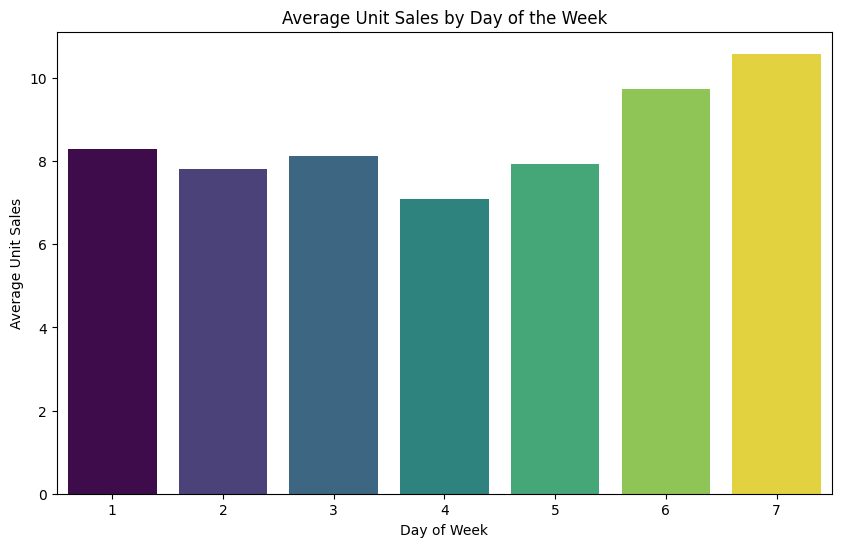

In [5]:
avg_sales_by_day = sales_df.groupby('day_of_week')['unit_sales'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(
    x='day_of_week', 
    y='unit_sales', 
    data=avg_sales_by_day, 
    palette='viridis', 
    hue='day_of_week',
    dodge=False, 
    legend=False
)
plt.title('Average Unit Sales by Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Unit Sales')
plt.show()

From the above barchart, we see that the average unit sales are higher during the weekends(6-saturday, 7-sunday) compared to rest of the week.

Since the integrated data is large (~ 13GB) with sales for 4096 items across 54 stores, we will bring down our analysis for only 10 items across all stores.

Next, we will check if any any particalur months generally have more sales than others.

In [6]:
sales_df['month'] = pd.to_datetime(sales_df['date']).dt.month

top_10_items = sales_df['item_nbr'].value_counts().head(10).index

# Filter to include only these 10 items
top_10_items_df = sales_df[sales_df['item_nbr'].isin(top_10_items)]

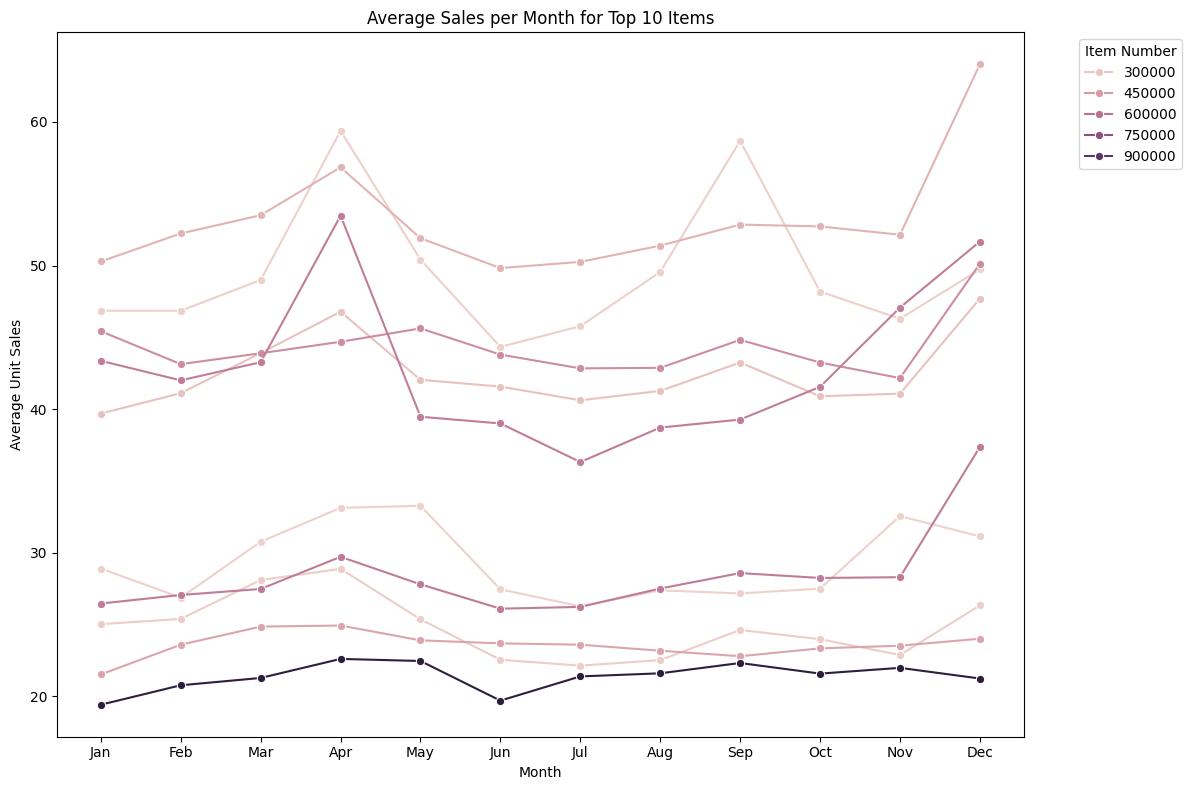

In [7]:
sales_df['month'] = pd.to_datetime(sales_df['date']).dt.month
monthly_item_sales = top_10_items_df.groupby(['month', 'item_nbr'])['unit_sales'].mean().reset_index()

plt.figure(figsize=(12, 8))
sns.lineplot(data=monthly_item_sales, x='month', y='unit_sales', hue='item_nbr', marker='o')
plt.title('Average Sales per Month for Top 10 Items')
plt.xlabel('Month')
plt.ylabel('Average Unit Sales')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Item Number', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

It is observed that higher number of units were sold in the early summer months (april-may) and december.

The below graph shows the average unit sales across all items.

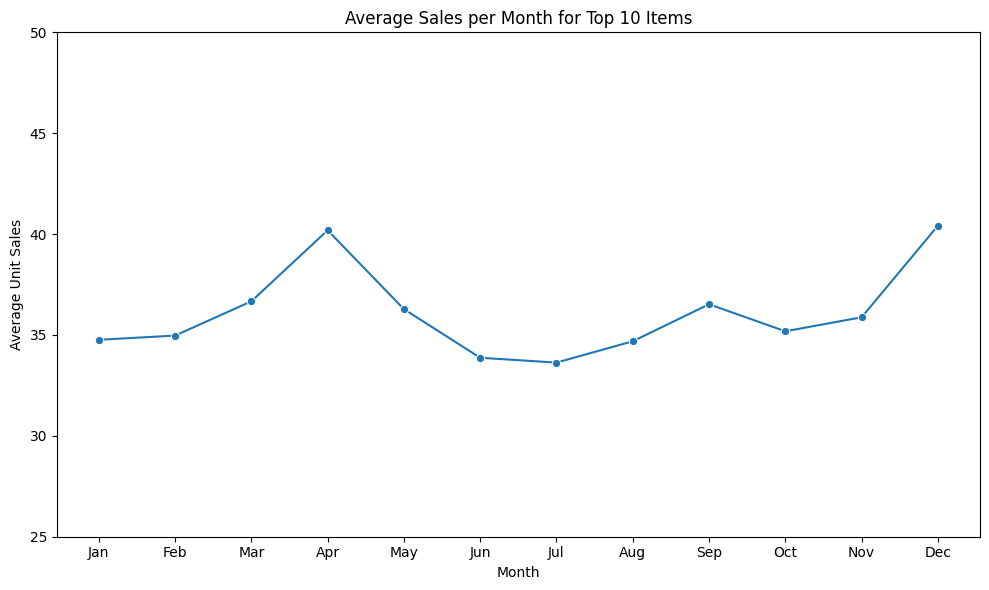

In [8]:
monthly_sales = top_10_items_df.groupby('month')['unit_sales'].mean().reset_index()

# Line Plot for average sales across months
plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_sales, x='month', y='unit_sales', marker='o')
plt.title('Average Sales per Month for Top 10 Items')
plt.xlabel('Month')
plt.ylabel('Average Unit Sales')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.ylim(25, 50)
plt.show()

Next, we need to understand if more units are sold if items are on promotion.

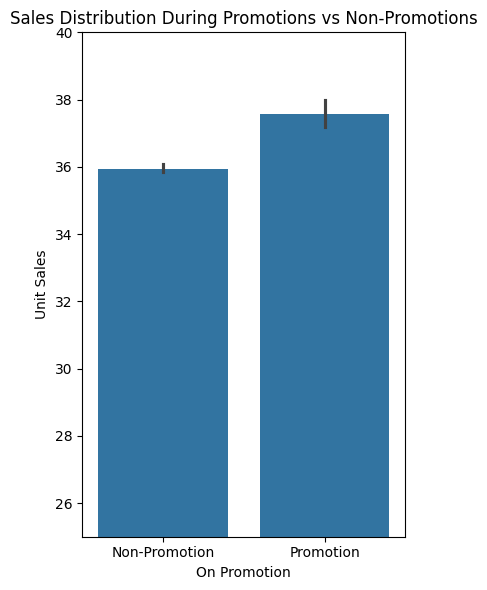

In [9]:
plt.figure(figsize=(4, 6))
sns.barplot(data=top_10_items_df, x='onpromotion', y='unit_sales')
plt.title('Sales Distribution During Promotions vs Non-Promotions')
plt.xlabel('On Promotion')
plt.ylabel('Unit Sales')
plt.xticks([0, 1], ['Non-Promotion', 'Promotion'])
plt.tight_layout()
plt.ylim(25, 40)
plt.show()

Looks like keeping the items on promotion does not lead to considerably more sales

Lets check if sales are higher than usual on the holidays.

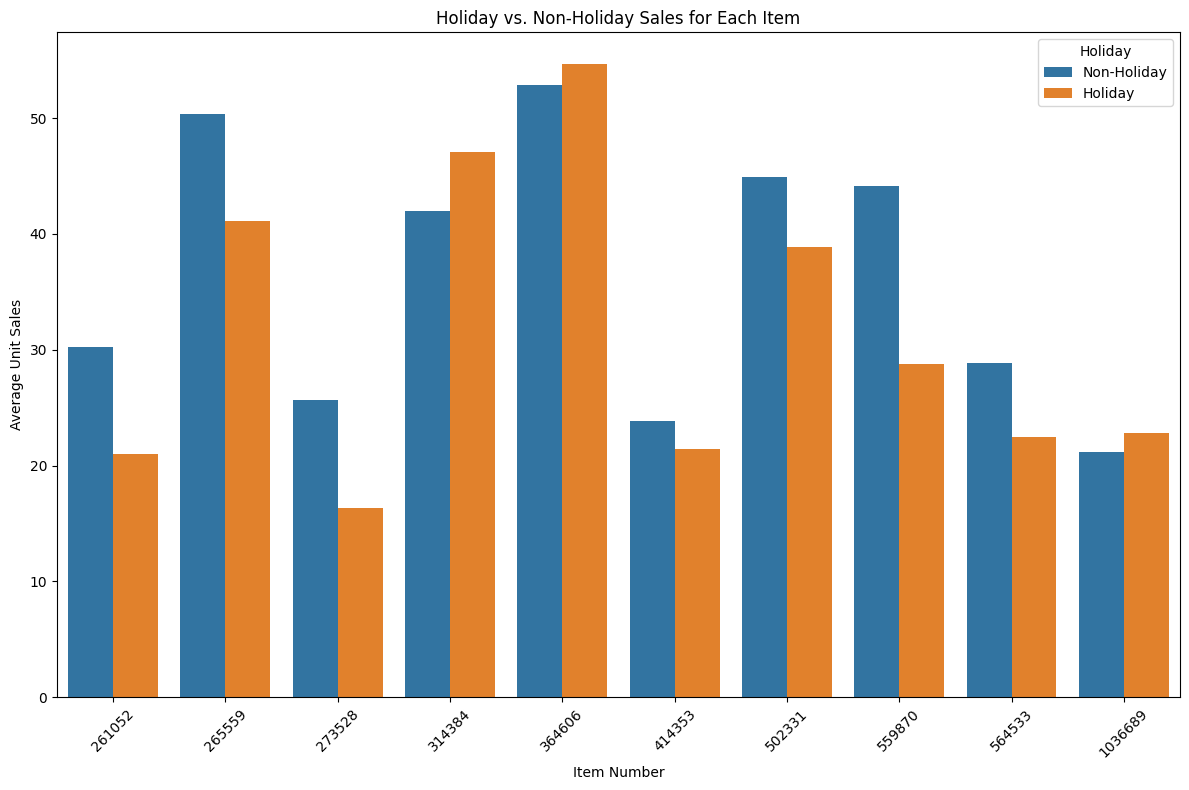

In [10]:
item_holiday_comparison = (
    top_10_items_df.groupby(['item_nbr', 'holiday'])['unit_sales']
    .mean()
    .reset_index()
)

plt.figure(figsize=(12, 8))
sns.barplot(
    data=item_holiday_comparison, 
    x='item_nbr', 
    y='unit_sales', 
    hue='holiday', 
    ci=None
)
plt.title('Holiday vs. Non-Holiday Sales for Each Item')
plt.xlabel('Item Number')
plt.ylabel('Average Unit Sales')
plt.legend(title='Holiday', labels=['Non-Holiday', 'Holiday'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

looks like that except for 2 items, holidays dont lead to higher sales. Now, lets check if the day before holiday have more sales on average.

           day_category  unit_sales
0  1 Day Before Holiday   21.100000
1               Holiday   31.560459
2           Non-Holiday   36.467351


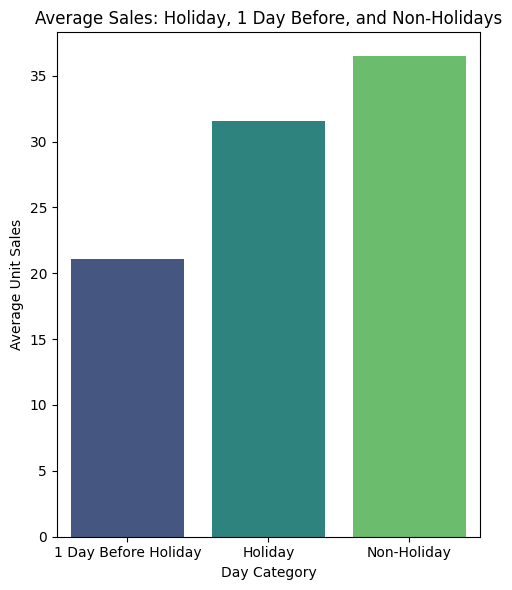

In [11]:
top_10_items_df = top_10_items_df.copy()

top_10_items_df['holiday_shift'] = top_10_items_df['holiday'].shift(-1)

# function to categorize the days
def categorize_day(row):
    if row['holiday'] == 1:
        return 'Holiday'
    elif row['holiday_shift'] == 1:
        return '1 Day Before Holiday'
    else:
        return 'Non-Holiday'

top_10_items_df['day_category'] = top_10_items_df.apply(categorize_day, axis=1)

# Calculate the average sales by day category
avg_sales_by_day_category = top_10_items_df.groupby('day_category')['unit_sales'].mean().reset_index()

print(avg_sales_by_day_category)

plt.figure(figsize=(5, 6))
sns.barplot(data=avg_sales_by_day_category, x='day_category', y='unit_sales', palette='viridis', hue='day_category')
plt.title('Average Sales: Holiday, 1 Day Before, and Non-Holidays')
plt.xlabel('Day Category')
plt.ylabel('Average Unit Sales')
plt.tight_layout()
plt.show()


We found that the average sales on the holiday and the day before holiday are less than the regular days. 

Lets analyse the sales bt aggregating the data by date, summing the unit_sales across all stores for top 10 items for one year

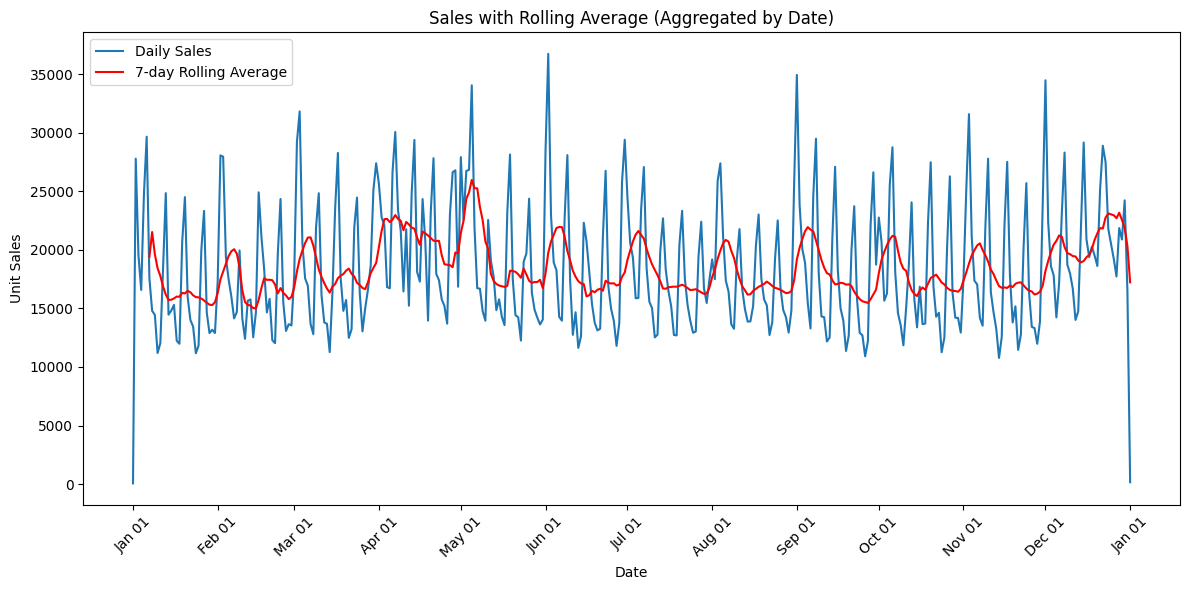

In [12]:
# Aggregate the data by date, summing the unit_sales across all stores and items
aggregated_data = top_10_items_df.groupby('date')['unit_sales'].sum().reset_index()
aggregated_data['date'] = pd.to_datetime(aggregated_data['date'])

# Calculate the 7-day rolling average for unit_sales
aggregated_data['rolling_avg'] = aggregated_data['unit_sales'].rolling(window=7).mean()

first_365_days = aggregated_data.head(365)

plt.figure(figsize=(12, 6))

sns.lineplot(data=first_365_days, x='date', y='unit_sales', label='Daily Sales')

# Plot the 7-day rolling average
sns.lineplot(data=first_365_days, x='date', y='rolling_avg', label='7-day Rolling Average', color='red')

plt.title('Sales with Rolling Average (Aggregated by Date)')
plt.xlabel('Date')
plt.ylabel('Unit Sales')

month_starts = first_365_days[first_365_days['date'].dt.is_month_start]['date']

plt.xticks(ticks=month_starts, labels=month_starts.dt.strftime('%b %d'), rotation=45)
plt.tight_layout()
plt.legend()
plt.show()


We can observe that there are spikes at the start of each month

The below plot shows the average sales by city.

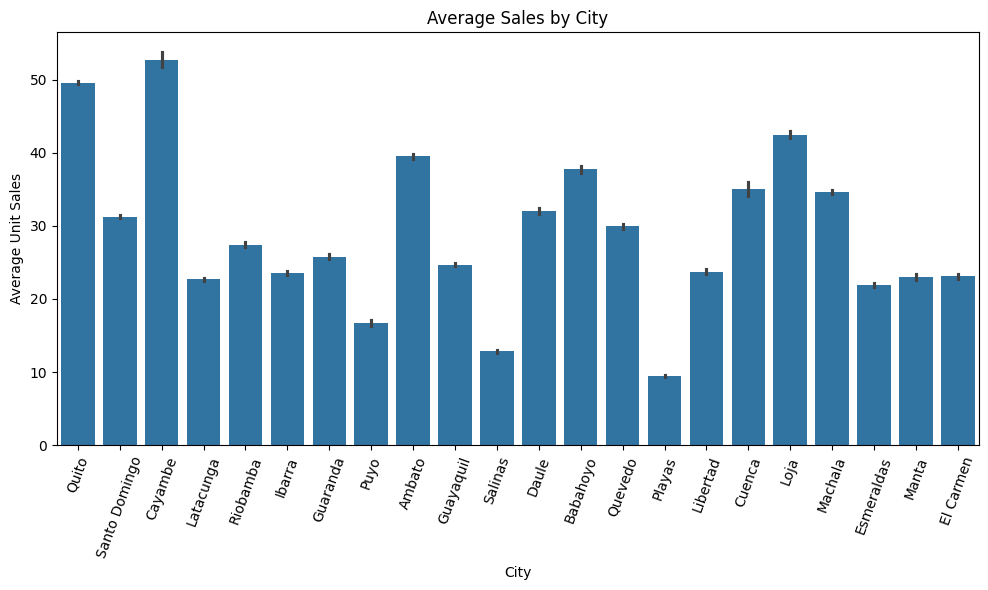

In [13]:
plt.figure(figsize=(10, 6))
sns.barplot(data=top_10_items_df, x='city', y='unit_sales')
plt.title('Average Sales by City')
plt.xlabel('City')
plt.ylabel('Average Unit Sales')
plt.xticks(rotation=70)
plt.tight_layout()
plt.show()

There exist cities with considerably more sales on average than the others

The below plot shows the average sales for each store.

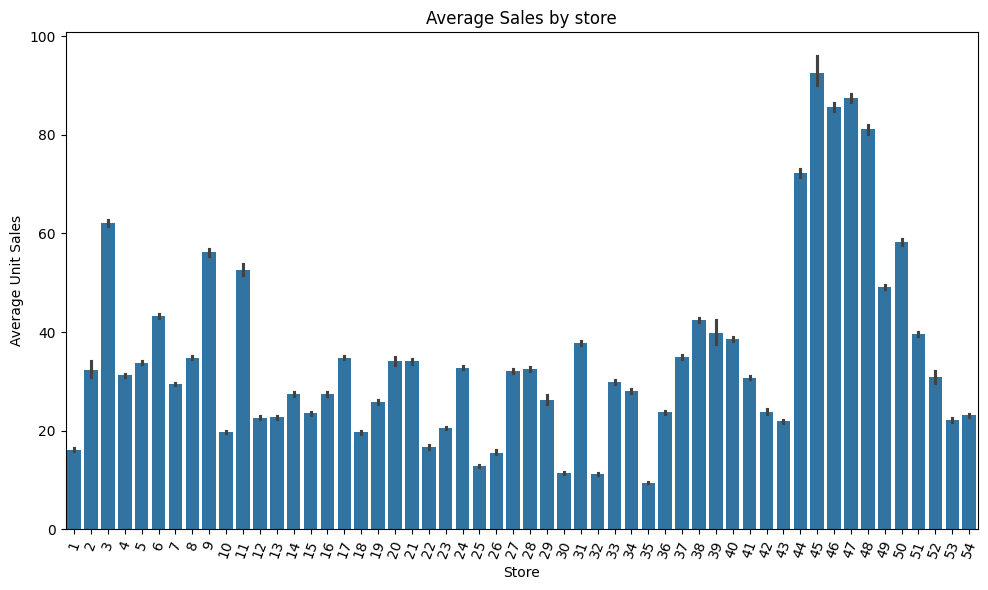

In [14]:
plt.figure(figsize=(10, 6))
sns.barplot(data=top_10_items_df, x='store_nbr', y='unit_sales')
plt.title('Average Sales by store')
plt.xlabel('Store')
plt.ylabel('Average Unit Sales')
plt.xticks(rotation=70)
plt.tight_layout()
plt.show()

Certain stores sell significantly more than the others

# Analysing the sales at store level. 

We look closely into store-id 26 and perform EDA to understand the factors that affect the total sales in this store before building a sales forecasting model. We selected this store because it has the highest number of rows.


In [15]:
store_date_sales = sales_df.groupby(['store_nbr', 'date'], as_index=False).agg({
    'unit_sales': 'sum',           # Sum of unit_sales
    'onpromotion': 'first',        # First value of onpromotion
    'transactions': 'first',       # First value of transactions
    'dcoilwtico': 'first',         # First value of dcoilwtico (or any other relevant column)
    'oilprice_label': 'first',     # First value of oilprice_label
    'city': 'first',               # First value of city
    'type_A': 'first',             # First value of type_A
    'type_B': 'first',             # First value of type_B
    'type_C': 'first',             # First value of type_C
    'type_D': 'first',             # First value of type_D
    'type_E': 'first',             # First value of type_E
    'holiday': 'first',            # First value of holiday
    'class': 'first',              # First value of class
    'day_of_week': 'first',        # First value of day_of_week
    'weekly_avg_sales': 'sum',    # Sum value of weekly_avg_sales
    'month' : 'first'
})

Are there any type of stores where the sales are higher?

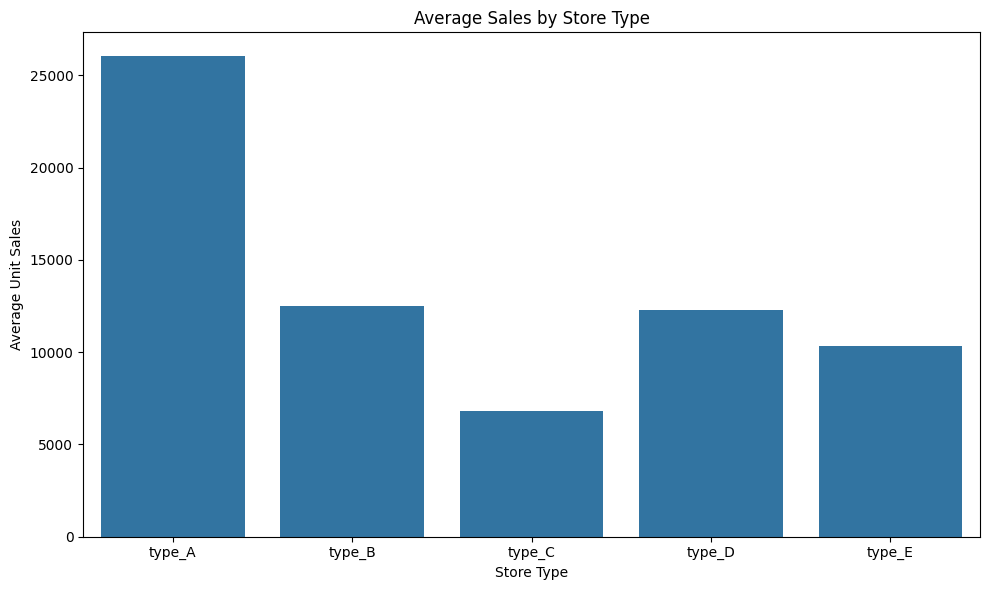

In [16]:
store_types = ['type_A', 'type_B', 'type_C', 'type_D', 'type_E']

# Create a new column to identify the store type
store_date_sales['store_type'] = store_date_sales[store_types].idxmax(axis=1)

# Now group by the store type and calculate the average unit_sales
avg_sales_by_type = store_date_sales.groupby('store_type')['unit_sales'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=avg_sales_by_type, x='store_type', y='unit_sales')
plt.title('Average Sales by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Average Unit Sales')
plt.tight_layout()
plt.show()

We have 5 different store types in the dataset which represent the size of the store, such as hyper market or local. and we found that type A stores have a lot more sales than the other types.

Lets focus on one particular store and try to understand the sale trends.

In [17]:
store_26_df = store_date_sales[store_date_sales['store_nbr'] == 26]

store_26_df.head()

store_nbr        date  unit_sales  onpromotion  transactions  \
38832         26  2013-01-02    5653.413            0          1008   
38833         26  2013-01-03    3477.559            0           813   
38834         26  2013-01-04    3538.449            0           813   
38835         26  2013-01-05    5503.186            0          1081   
38836         26  2013-01-06    5584.290            0          1075   

       dcoilwtico  oilprice_label       city  type_A  type_B  type_C  type_D  \
38832       93.14              23  Guayaquil   False   False   False    True   
38833       92.97              23  Guayaquil   False   False   False    True   
38834       93.12              23  Guayaquil   False   False   False    True   
38835       94.76              23  Guayaquil   False   False   False    True   
38836       94.76              23  Guayaquil   False   False   False    True   

       type_E  holiday  class  day_of_week  weekly_avg_sales  month store_type  
38832   False        0   2712            3          5653.413      1     type_D  
38833   False        0   1045            4          4402.074      1     type_D  
38834   False        0   2712            5          4158.910      1     type_D  
38835   False        0   2712            6          4778.621      1     type_D  
38836   False        0   2712            7          4912.074      1     type_D

Checking for trends using the rolling average over 7 day window

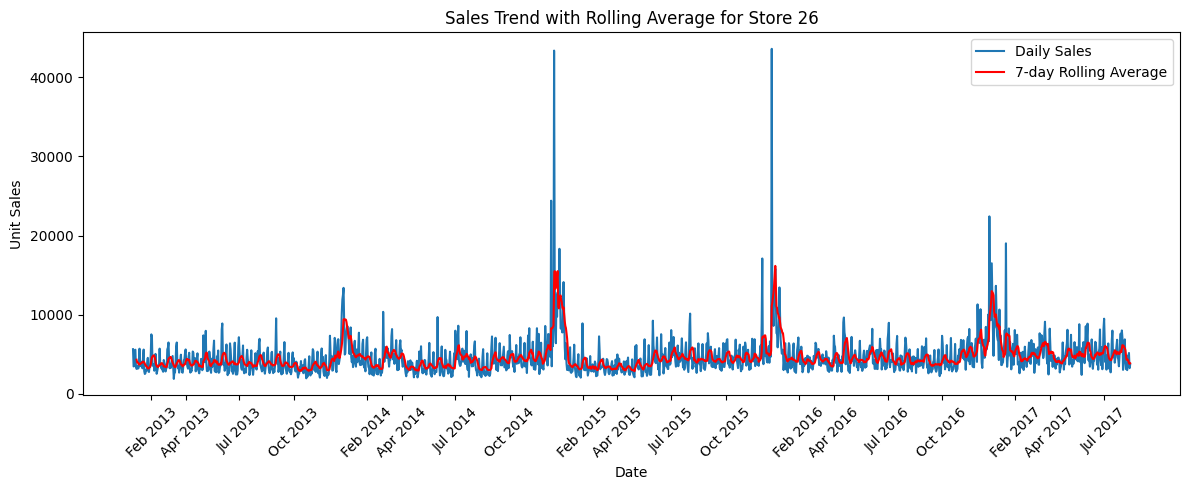

In [24]:
store_26_df['date'] = pd.to_datetime(store_26_df['date'])

# Calculate the 7-day rolling average for unit sales
store_26_df['rolling_avg'] = store_26_df['unit_sales'].rolling(window=7).mean()

xticks = store_26_df[
    store_26_df['date'].dt.strftime('%m-%d').isin(['02-02', '04-01', '07-01', '10-01'])
]['date']

# Plot daily sales and the rolling average
plt.figure(figsize=(12, 5))
sns.lineplot(data=store_26_df, x='date', y='unit_sales', label='Daily Sales')
sns.lineplot(data=store_26_df, x='date', y='rolling_avg', label='7-day Rolling Average', color='red')

# Add title and labels
plt.title('Sales Trend with Rolling Average for Store 26')
plt.xlabel('Date')
plt.ylabel('Unit Sales')

# Format xticks for better readability
plt.xticks(xticks, labels=xticks.dt.strftime('%b %Y'), rotation=45)

# Adjust layout and add legend
plt.tight_layout()
plt.legend()
plt.show()


We can observe the peaks during the end of each year

Lets drill down and analyse at a monthly level to better the trends

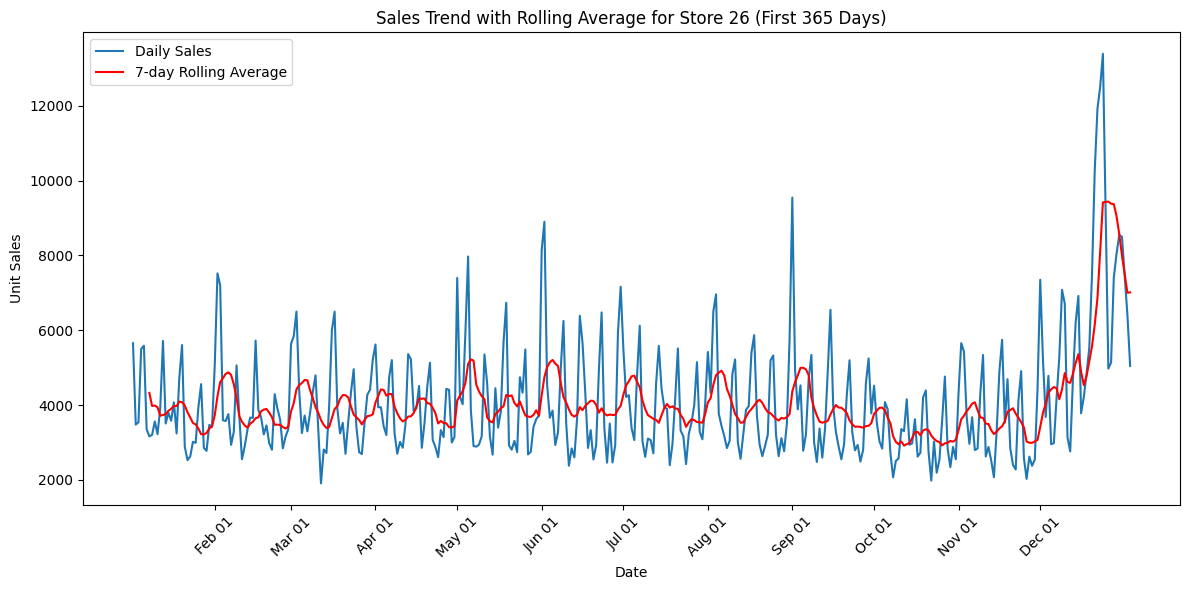

In [25]:
# Filter for the first 365 dates
store_26_first_year = store_26_df.head(365).copy()

# Ensure 'date' is in datetime format
store_26_first_year['date'] = pd.to_datetime(store_26_first_year['date'])

# Calculate the rolling average for the filtered data
store_26_first_year['rolling_avg'] = store_26_first_year['unit_sales'].rolling(window=7).mean()

month_starts = store_26_first_year[store_26_first_year['date'].dt.is_month_start]['date']

plt.figure(figsize=(12, 6))
sns.lineplot(data=store_26_first_year, x='date', y='unit_sales', label='Daily Sales')
sns.lineplot(data=store_26_first_year, x='date', y='rolling_avg', label='7-day Rolling Average', color='red')
plt.title('Sales Trend with Rolling Average for Store 26 (First 365 Days)')
plt.xlabel('Date')
plt.ylabel('Unit Sales')


plt.xticks(ticks=month_starts, labels=month_starts.dt.strftime('%b %d'), rotation=45)

plt.tight_layout()
plt.legend()
plt.show()


We can again see that the start of the month generally have higher sales compared to rest of the month with december being an exception.

Checking if day of week affects the sales in this store.

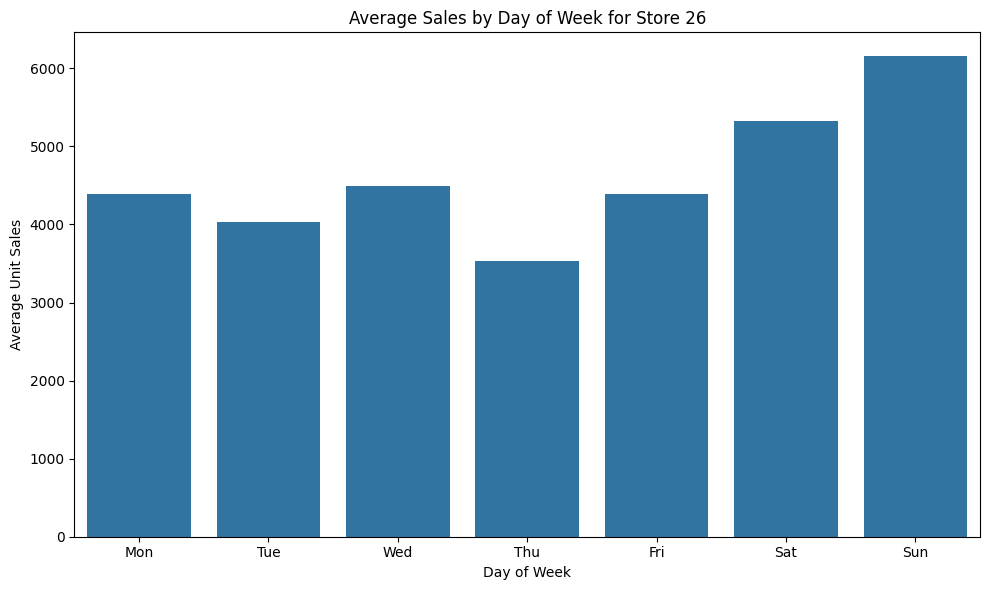

In [26]:
avg_sales_day_of_week = store_26_df.groupby('day_of_week')['unit_sales'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=avg_sales_day_of_week, x='day_of_week', y='unit_sales')
plt.title('Average Sales by Day of Week for Store 26')
plt.xlabel('Day of Week')
plt.ylabel('Average Unit Sales')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.tight_layout()
plt.show()

Checking if any particular month have higher sales 

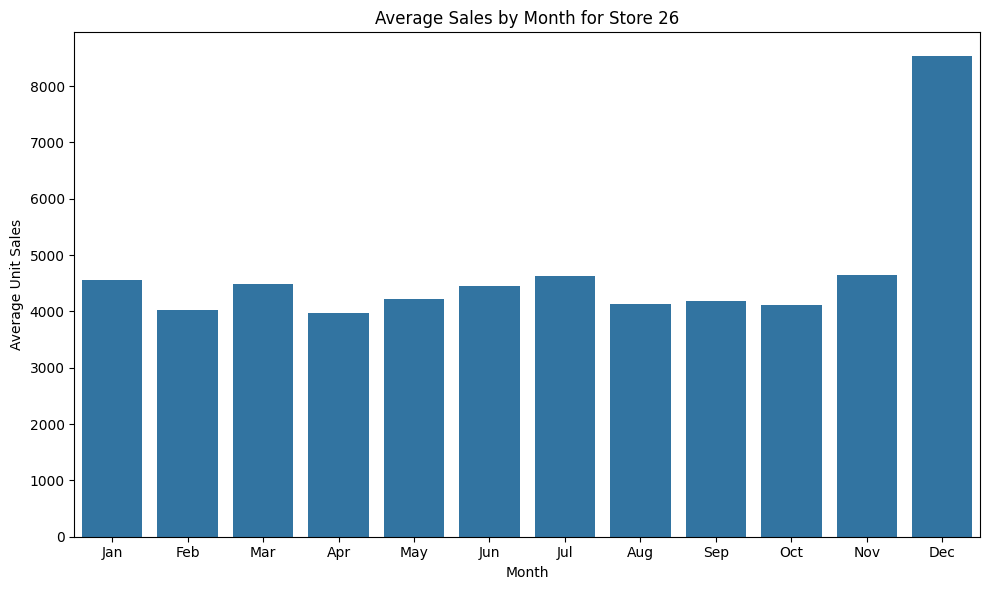

In [27]:
store_26_df['month'] = pd.to_datetime(store_26_df['date']).dt.month

# Plot average sales by month
avg_sales_month = store_26_df.groupby('month')['unit_sales'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=avg_sales_month, x='month', y='unit_sales')
plt.title('Average Sales by Month for Store 26')
plt.xlabel('Month')
plt.ylabel('Average Unit Sales')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.show()

Does the oil price have any effect on the overall sales

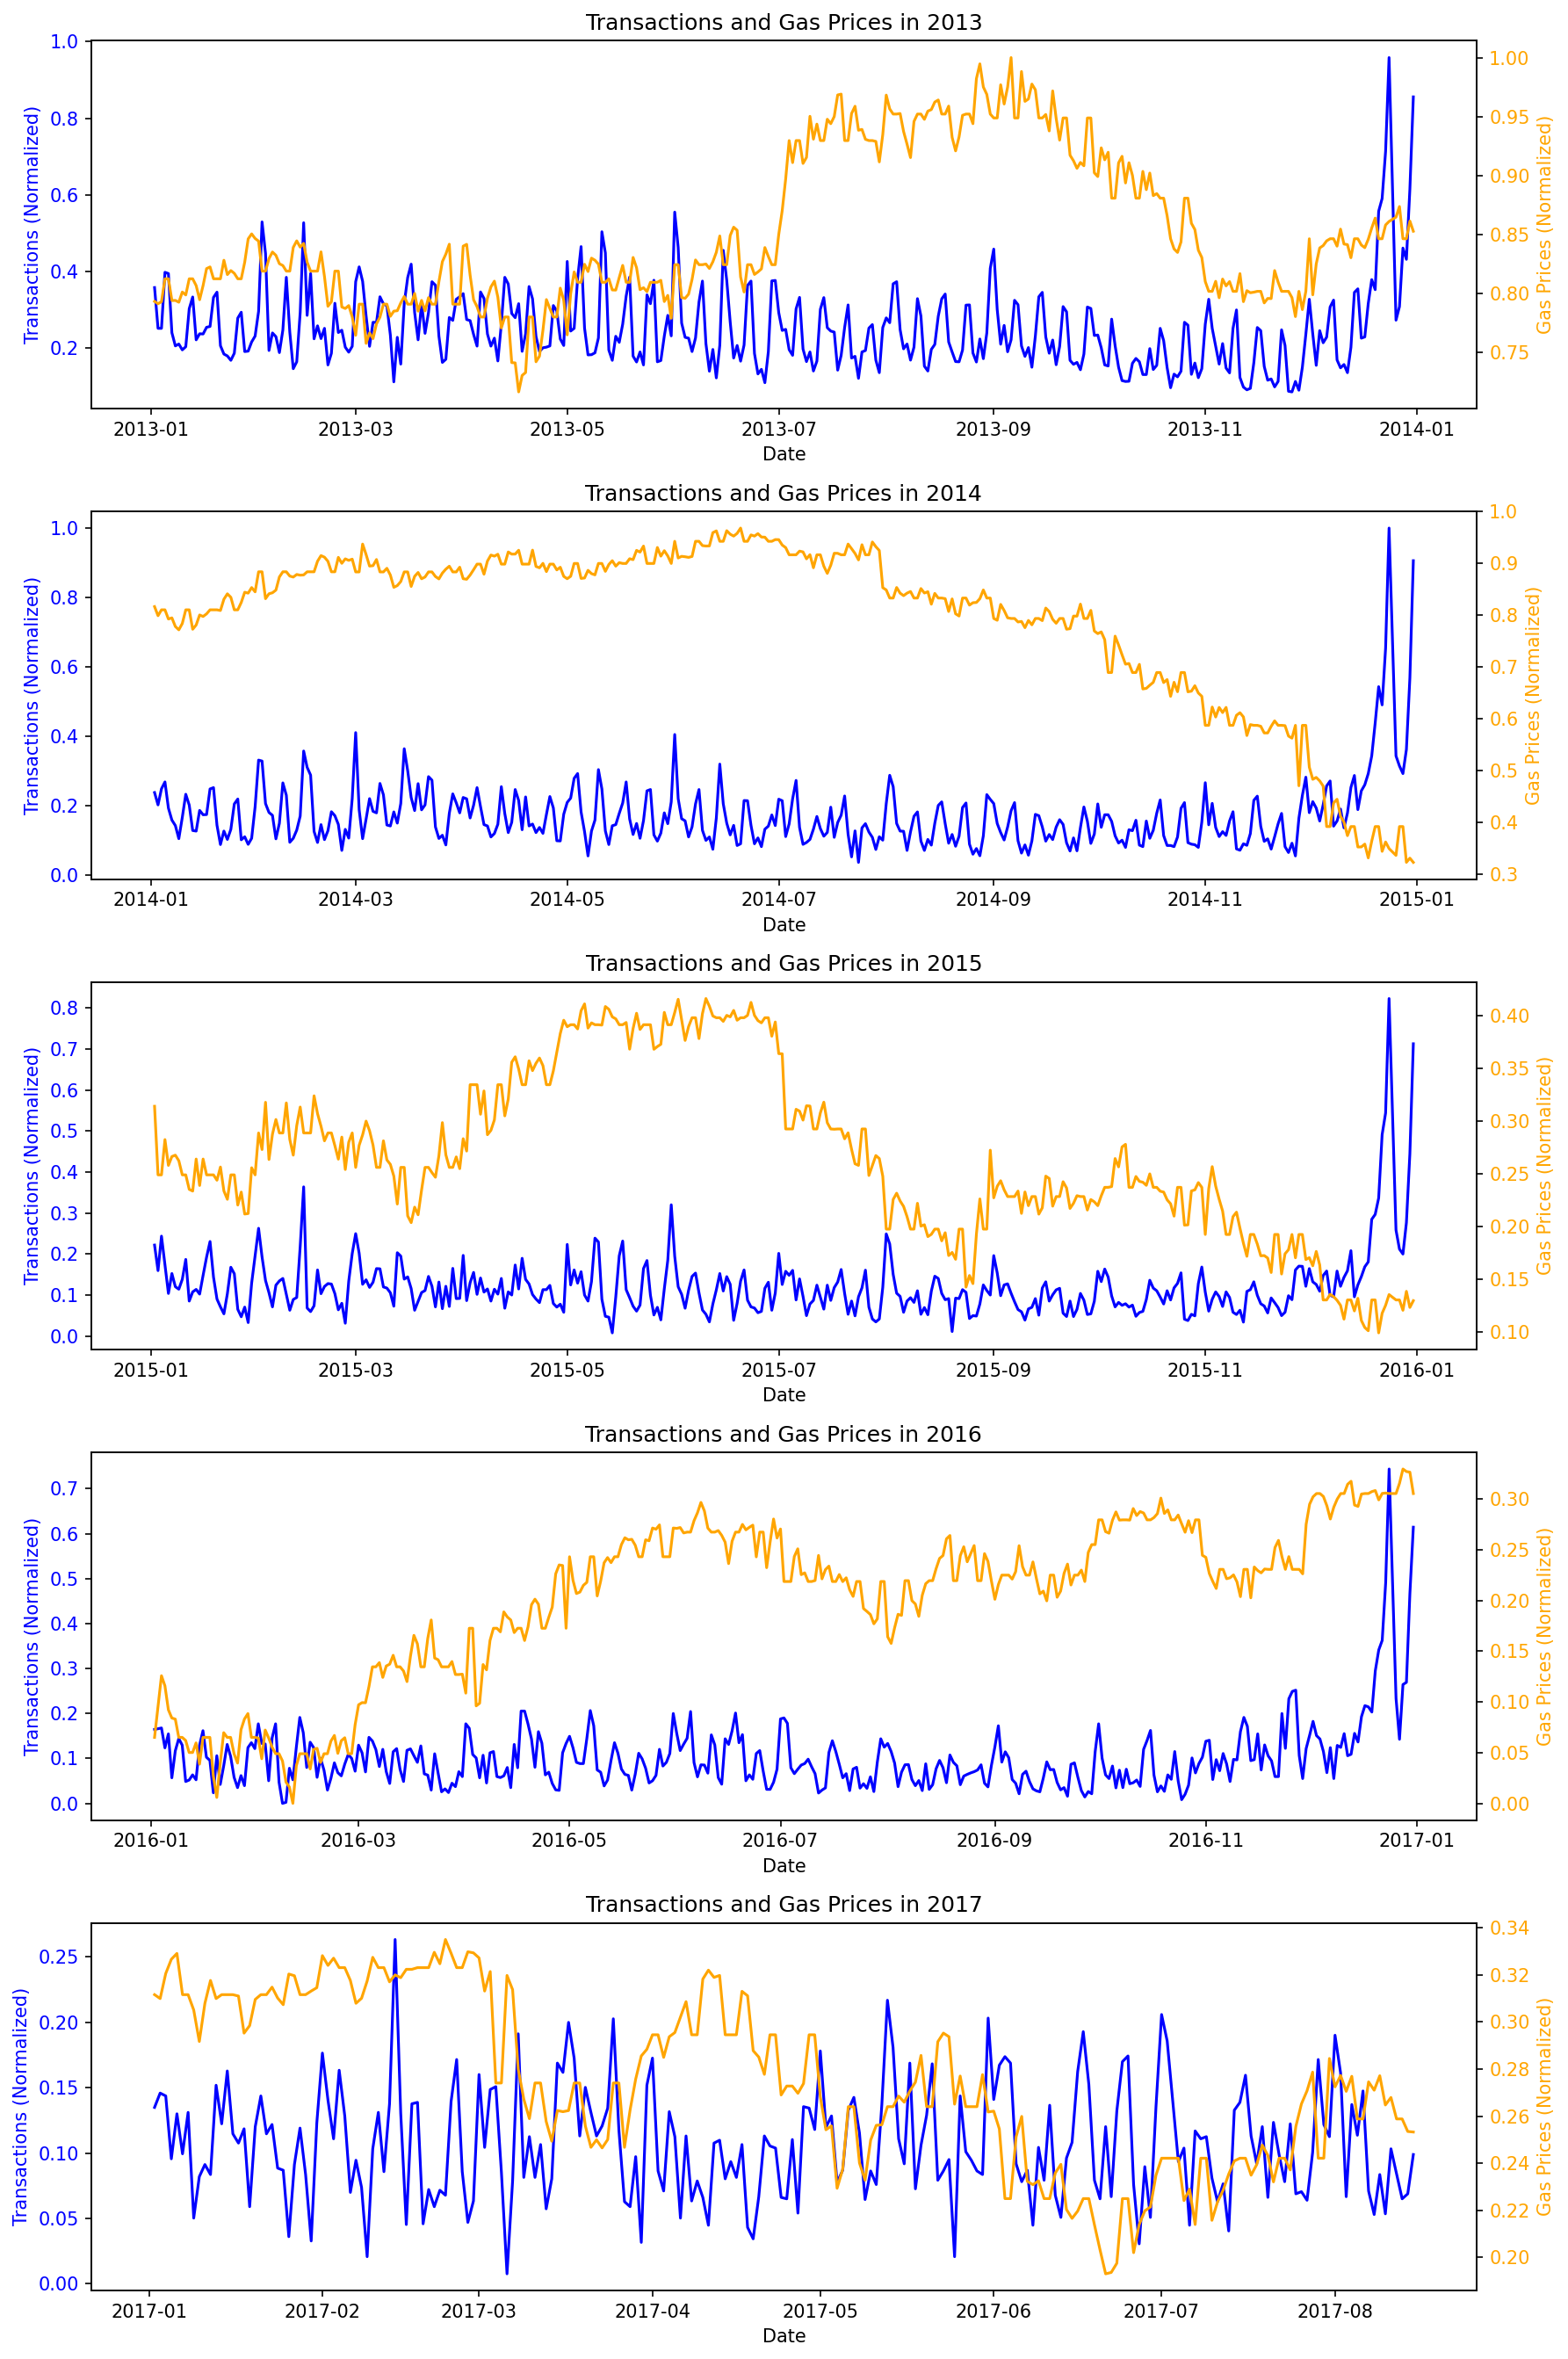

In [50]:
def normalize_max_min(col):
    a_min = col.min()
    a_max = col.max()
    norm_data = (col - a_min) / (a_max - a_min)
    return norm_data

# Normalize and prepare the store sales data
store_sales_transactions_df = store_26_df.copy()
store_sales_transactions_df['transactions_norm'] = normalize_max_min(store_sales_transactions_df['transactions'])
store_sales_transactions_df['date'] = pd.to_datetime(store_sales_transactions_df['date'])
store_sales_transactions_df['year'] = store_sales_transactions_df['date'].dt.year
store_sales_transactions_df = store_sales_transactions_df.sort_values('date')

# Normalize and prepare the oil price data
store_sales_oil_df = store_26_df.copy()
store_sales_oil_df['dcoilwtico_norm'] = normalize_max_min(store_sales_oil_df['dcoilwtico'])
store_sales_oil_df['date'] = pd.to_datetime(store_sales_oil_df['date'])
store_sales_oil_df['year'] = store_sales_oil_df['date'].dt.year
store_sales_oil_df = store_sales_oil_df.sort_values('date')

# Unique years for plotting
years = store_sales_transactions_df['year'].unique()

# Plotting with higher resolution
fig, axes = plt.subplots(nrows=len(years), ncols=1, figsize=(12, 18), dpi=150)  # Increased DPI for better clarity

for ax, yr in zip(axes, years):
    # Subset data for the specific year
    subset_transactions = store_sales_transactions_df[store_sales_transactions_df['year'] == yr]
    subset_oil = store_sales_oil_df[store_sales_oil_df['year'] == yr]
    
    # Plot smoothed transactions on the primary y-axis
    ax.plot(subset_transactions['date'], subset_transactions['transactions_norm'], label='Transactions', color='blue')
    ax.set_ylabel('Transactions (Normalized)', color='blue')
    ax.tick_params(axis='y', labelcolor='blue')
    
    # Plot smoothed oil prices on the secondary y-axis
    ax2 = ax.twinx()
    ax2.plot(subset_oil['date'], subset_oil['dcoilwtico_norm'], label='Gas Price', color='orange')
    ax2.set_ylabel('Gas Prices (Normalized)', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')
    
    # Title and X-axis label
    ax.set_title(f'Transactions and Gas Prices in {yr}')
    ax.set_xlabel('Date')

# Adjust layout
plt.tight_layout()
plt.show()


  Here we have plotted the sales for the calendar year and also the oil prices on a different axes and we if we look closely, the spikes in the sales corresponds to dips in the oil prices. 

Next, we will see if putting items on promotions helps to generate more sales

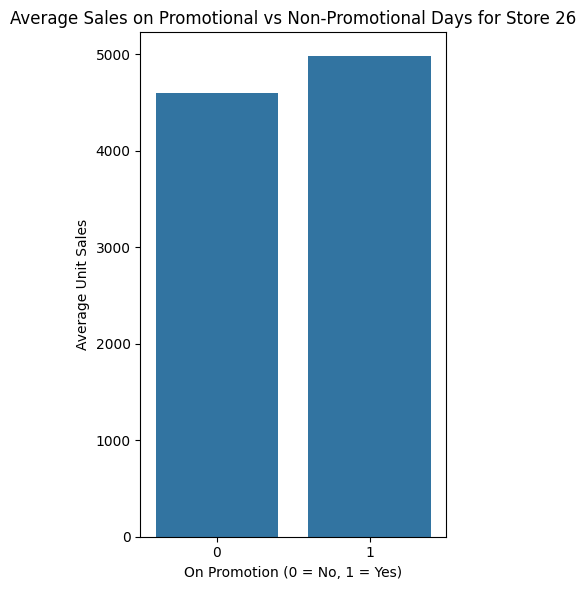

In [29]:
avg_sales_promotion = store_26_df.groupby('onpromotion')['unit_sales'].mean().reset_index()

plt.figure(figsize=(4, 6))
sns.barplot(data=avg_sales_promotion, x='onpromotion', y='unit_sales')
plt.title('Average Sales on Promotional vs Non-Promotional Days for Store 26')
plt.xlabel('On Promotion (0 = No, 1 = Yes)')
plt.ylabel('Average Unit Sales')
plt.tight_layout()
plt.show()

Comparing the perishable and non-perishable sales


Analyzing perishable vs non-perishable items...


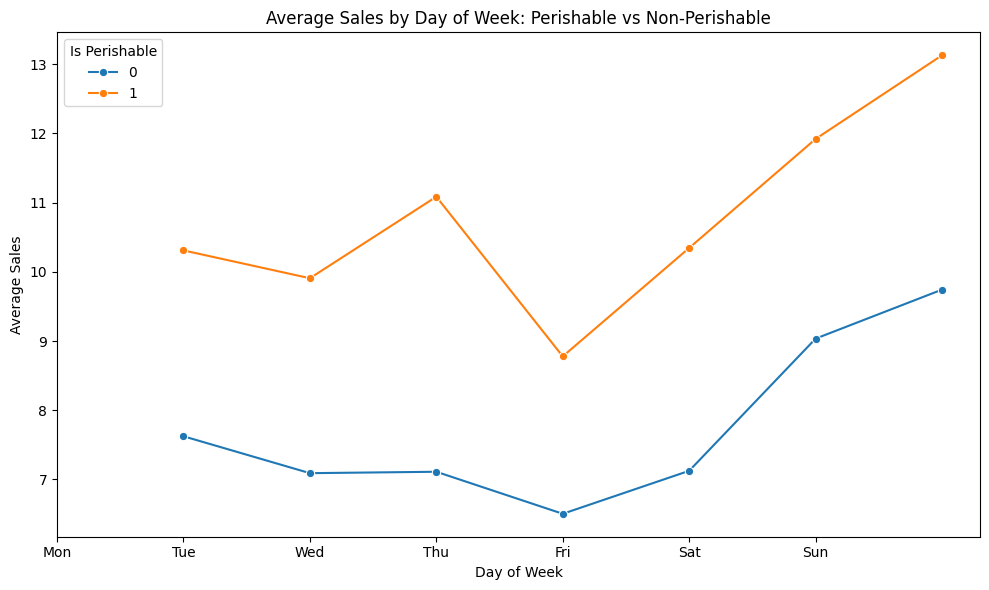

In [54]:
print("\nAnalyzing perishable vs non-perishable items...")
perishable_daily = sales_df.groupby(['perishable', 'day_of_week'])['unit_sales'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=perishable_daily, x='day_of_week', y='unit_sales', hue='perishable',
             marker='o')
plt.title('Average Sales by Day of Week: Perishable vs Non-Perishable')
plt.xlabel('Day of Week')
plt.ylabel('Average Sales')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.legend(title='Is Perishable')
plt.tight_layout()
plt.show()

Comparing the trend of monthly average sales for perishable and non-perishable items 

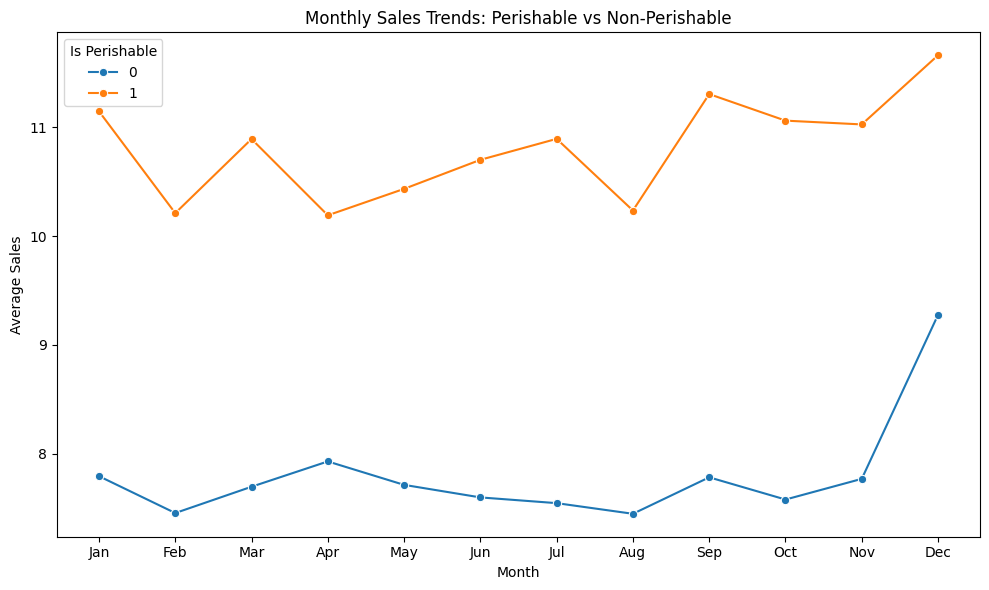

In [53]:
monthly_perishable = sales_df.groupby(['month', 'perishable'])['unit_sales'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_perishable, x='month', y='unit_sales', 
             hue='perishable',
             marker='o')
plt.title('Monthly Sales Trends: Perishable vs Non-Perishable')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.legend(title='Is Perishable')
plt.tight_layout()
plt.show()

Comparing the affect of promotions for perishable and non-perishable items

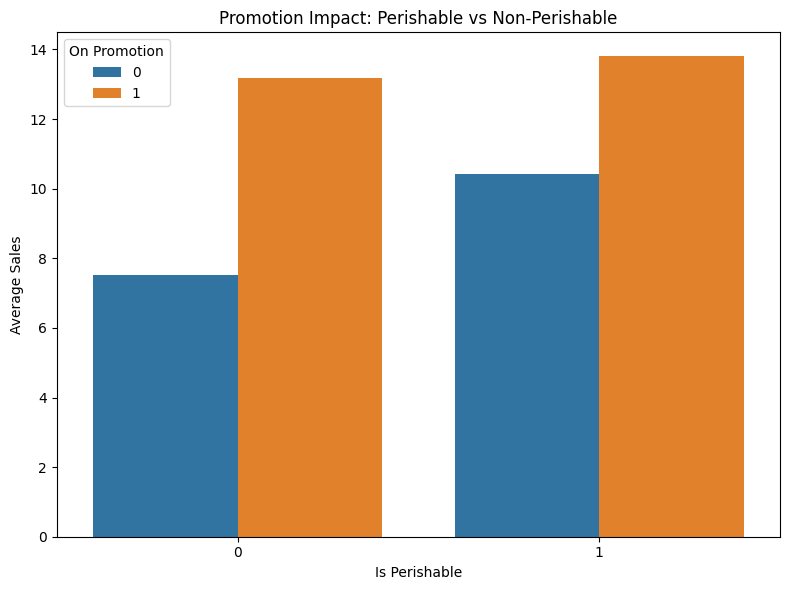

In [32]:
promo_impact = sales_df.groupby(['perishable', 'onpromotion'])['unit_sales'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(data=promo_impact, x='perishable', y='unit_sales', hue='onpromotion')
plt.title('Promotion Impact: Perishable vs Non-Perishable')
plt.xlabel('Is Perishable')
plt.ylabel('Average Sales')
plt.legend(title='On Promotion')
plt.tight_layout()
plt.show()

Looks like the promotion has an impact on the salea in this store for both perishable and non-perishable items

# Forecasting model to predict the sales for a store.

In this section, we will build a forecasting model to predict the sales for a particular store.

Load sales data from CSV files for a specific store number 26. Converts date column to datetime format and sets it as the index. We sort the data based of the date so that we make the train-test split based on the date range

In [33]:
def load_and_prepare_data(store_number=26):
    print("Loading data...")
    #sales_df = pd.read_csv("datasets/integrated_data.csv")
    
    # Filter for specific store
    store_data = pd.read_csv("datasets/store_data.csv")
    
    # Convert date to datetime and set as index
    store_data['date'] = pd.to_datetime(store_data['date'])
    store_data = store_data.set_index('date')
    
    # Sort by date
    store_data = store_data.sort_index()
    
    print(f"Data loaded for store {store_number}")
    print(f"Date range: {store_data.index.min()} to {store_data.index.max()}")
    print(f"Number of records: {len(store_data)}")
    
    return store_data

Aggregates sales data to daily level by summing unit sales. Creates a continuous date range and fills any missing values using forward and backward fill methods. Ensures data is available for all dates for time series analysis.

In [34]:
def preprocess_data(store_data):
    # Aggregate sales to daily level
    daily_sales = store_data.groupby('date')['unit_sales'].sum().reset_index()
    daily_sales.set_index('date', inplace=True)
    
    # Ensure continuous date range
    date_range = pd.date_range(start=daily_sales.index.min(),
                             end=daily_sales.index.max(),
                             freq='D')
    
    daily_sales = daily_sales.reindex(date_range)
    
    # Fill missing values
    daily_sales = daily_sales.fillna(method='ffill').fillna(method='bfill')
    
    return daily_sales

Below function creates various time-based features including day of week, month, and year. Generates lag features for 1, 7, and 14 days prior. Calculates rolling means for 7 and 14-day windows and adds holiday event indicators. We handle the handle missing values by dropping them.

In [35]:
def create_features(data):
    df = data.copy()
    
    # Date-based features
    df['day_of_week'] = df.index.dayofweek
    df['day_of_month'] = df.index.day
    df['month'] = df.index.month
    df['year'] = df.index.year
    
    # Lag features
    df['lag_1'] = df['unit_sales'].shift(1)
    df['lag_7'] = df['unit_sales'].shift(7)
    df['lag_14'] = df['unit_sales'].shift(14)
    
    # Rolling means
    df['rolling_mean_7'] = df['unit_sales'].rolling(window=7).mean()
    df['rolling_mean_14'] = df['unit_sales'].rolling(window=14).mean()
    
    # Holiday and special event features
    df['is_holiday'] = (df['day_of_week'].isin([5, 6])).astype(int)
    df['is_month_end'] = (df.index.day >= 28).astype(int)
    
    # Drop NaN values
    df = df.dropna()
    
    return df

We split the data into training and testing sets based on a specified ratio (here we used 80-20 split). We return separate training and testing dataframes.

In [36]:
def train_test_split_ts(data, train_size=0.8):
    split_idx = int(len(data) * train_size)
    train_data = data.iloc[:split_idx].copy()
    test_data = data.iloc[split_idx:].copy()
    
    print("\nTraining set:")
    print(f"Start date: {train_data.index.min()}")
    print(f"End date: {train_data.index.max()}")
    print(f"Number of samples: {len(train_data)}")
    
    print("\nTesting set:")
    print(f"Start date: {test_data.index.min()}")
    print(f"End date: {test_data.index.max()}")
    print(f"Number of samples: {len(test_data)}")
    
    return train_data, test_data

Below function fits a SARIMA model with additional features like spike indicators and exogenous variables. Uses preset parameters for seasonal and non-seasonal components. Includes holiday, month-end, spike indicators, and rolling means. Returns the fitted model and exogenous variables.

In [37]:
def fit_sarima_model(train_data):
    # Calculate spike indicator
    rolling_std = train_data['unit_sales'].rolling(window=30).std()
    train_data['is_spike'] = (train_data['unit_sales'] > 
                             (train_data['unit_sales'].rolling(window=30).mean() + 2*rolling_std)).astype(int)
    
    # Create exogenous variables
    exog = train_data[['is_holiday', 'is_month_end', 'is_spike', 
                      'rolling_mean_7', 'day_of_week']]
    
    # SARIMA parameters
    order = (2, 1, 2)
    seasonal_order = (2, 1, 1, 7)
    print("Fitting SARIMA model...")
    model = SARIMAX(
        train_data['unit_sales'],
        exog=exog,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    
    results = model.fit(disp=False)
    
    return results, exog

Generates predictions using the fitted SARIMA model. Prepares test features including holiday and spike indicators. Returns both point predictions and confidence intervals for the forecast period.

In [38]:
def make_predictions(model, test_data, train_data):
    # Prepare test features
    test_data['is_holiday'] = (test_data['day_of_week'].isin([5, 6])).astype(int)
    test_data['is_month_end'] = (test_data.index.day >= 28).astype(int)
    
    rolling_std = test_data['unit_sales'].rolling(window=30, min_periods=1).std()
    test_data['is_spike'] = (test_data['unit_sales'] > 
                            (test_data['unit_sales'].rolling(window=30, min_periods=1).mean() + 
                             2*rolling_std)).astype(int)
    
    future_exog = test_data[['is_holiday', 'is_month_end', 'is_spike', 
                            'rolling_mean_7', 'day_of_week']]
    
    forecast = model.get_forecast(steps=len(test_data), exog=future_exog)
    predictions = forecast.predicted_mean
    conf_intervals = forecast.conf_int(alpha=0.1)
    
    return predictions, conf_intervals


Creates a visualization showing training data, actual test data, and predictions.

In [39]:
def plot_results(train_data, test_data, predictions, conf_intervals):
    plt.figure(figsize=(15, 8))
    
    # Plot data
    plt.plot(train_data.index, train_data['unit_sales'], 
             label='Training Data', color='blue', alpha=0.7)
    plt.plot(test_data.index, test_data['unit_sales'], 
             label='Actual Test Data', color='green', alpha=0.7)
    plt.plot(test_data.index, predictions, 
             label='Predictions', color='red', linewidth=2)
    
    # Plot confidence intervals
    plt.fill_between(test_data.index,
                    conf_intervals.iloc[:, 0],
                    conf_intervals.iloc[:, 1],
                    color='red', alpha=0.1)
    
    plt.title('Store 26 Sales - Actual vs Predicted')
    plt.xlabel('Date')
    plt.ylabel('Unit Sales')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

Calculates basic performance metrics including MAE, RMSE, and MAPE. Provides a simple evaluation of model performance by comparing actual and predicted values. Returns the calculated metrics.

In [40]:
def evaluate_model(test_data, predictions):
    mae = mean_absolute_error(test_data['unit_sales'], predictions)
    rmse = np.sqrt(mean_squared_error(test_data['unit_sales'], predictions))
    mape = np.mean(np.abs((test_data['unit_sales'] - predictions) / test_data['unit_sales'])) * 100
    
    print("\nModel Performance Metrics:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")
    
    return mae, rmse, mape

In [41]:
def evaluate_smoothed_predictions(test_data, predictions, window_size=7):
    
    # Convert predictions to series with the same index as test data
    preds_series = pd.Series(predictions, index=test_data.index)
    
    # Apply smoothing
    smoothed_actual = test_data['unit_sales'].rolling(window=window_size, center=True).mean()
    smoothed_preds = preds_series.rolling(window=window_size, center=True).mean()
    
    # Drop NaN values that result from smoothing
    mask = ~(smoothed_actual.isna() | smoothed_preds.isna())
    smoothed_actual = smoothed_actual[mask]
    smoothed_preds = smoothed_preds[mask]
    
    # Calculate metrics for raw data
    raw_metrics = {
        'Raw_RMSE': np.sqrt(mean_squared_error(test_data['unit_sales'], predictions)),
        'Raw_MAE': mean_absolute_error(test_data['unit_sales'], predictions),
        'Raw_MAPE': np.mean(np.abs((test_data['unit_sales'] - predictions) / test_data['unit_sales'])) * 100
    }
    
    # Calculate metrics for smoothed data
    smoothed_metrics = {
        'Smoothed_RMSE': np.sqrt(mean_squared_error(smoothed_actual, smoothed_preds)),
        'Smoothed_MAE': mean_absolute_error(smoothed_actual, smoothed_preds),
        'Smoothed_MAPE': np.mean(np.abs((smoothed_actual - smoothed_preds) / smoothed_actual)) * 100
    }
    
    print("\nMetrics Comparison (Raw vs Smoothed):")
    print("\nRaw Data Metrics:")
    for metric, value in raw_metrics.items():
        print(f"{metric}: {value:.2f}")
    
    print("\nSmoothed Data Metrics:")
    for metric, value in smoothed_metrics.items():
        print(f"{metric}: {value:.2f}")
    
    plt.figure(figsize=(15, 10))
    
    # Plot original data
    plt.subplot(2, 1, 1)
    plt.plot(test_data.index, test_data['unit_sales'], label='Actual', alpha=0.5)
    plt.plot(test_data.index, predictions, label='Predicted', alpha=0.5)
    plt.title('Original Data')
    plt.legend()
    plt.grid(True)
    
    # Plot smoothed data
    plt.subplot(2, 1, 2)
    plt.plot(smoothed_actual.index, smoothed_actual, label='Smoothed Actual', linewidth=2)
    plt.plot(smoothed_preds.index, smoothed_preds, label='Smoothed Predicted', linewidth=2)
    plt.title(f'Smoothed Data (Window Size: {window_size} days)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return {**raw_metrics, **smoothed_metrics}, smoothed_actual, smoothed_preds

We will now call the functions created above and asses the performance of the model. We will also plot three following graphs :<br>
1. Time series graph that shoes the training data and actual test data along with predictions.<br>
2. Closer look at the comparison between the actual test data vs the predicted sales.<br>
3. Smoothed and comapared the sales for the actual test data and the predicted sales so that we can better understand if the model has captured the trend.

Loading data...
Data loaded for store 26
Date range: 2013-01-02 00:00:00 to 2017-08-15 00:00:00
Number of records: 1791522

Training set:
Start date: 2013-01-16 00:00:00
End date: 2016-09-14 00:00:00
Number of samples: 1338

Testing set:
Start date: 2016-09-15 00:00:00
End date: 2017-08-15 00:00:00
Number of samples: 335
Fitting SARIMA model...


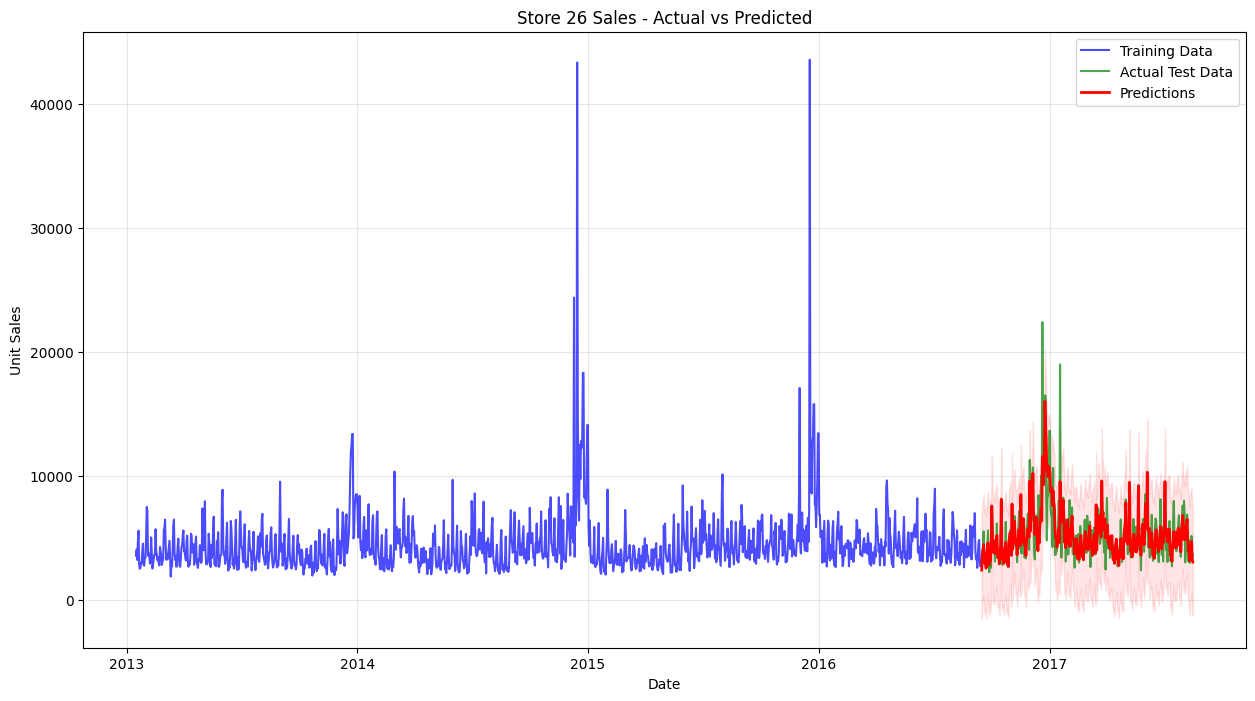


Metrics Comparison (Raw vs Smoothed):

Raw Data Metrics:
Raw_RMSE: 1412.85
Raw_MAE: 906.41
Raw_MAPE: 16.83

Smoothed Data Metrics:
Smoothed_RMSE: 645.64
Smoothed_MAE: 442.73
Smoothed_MAPE: 7.58


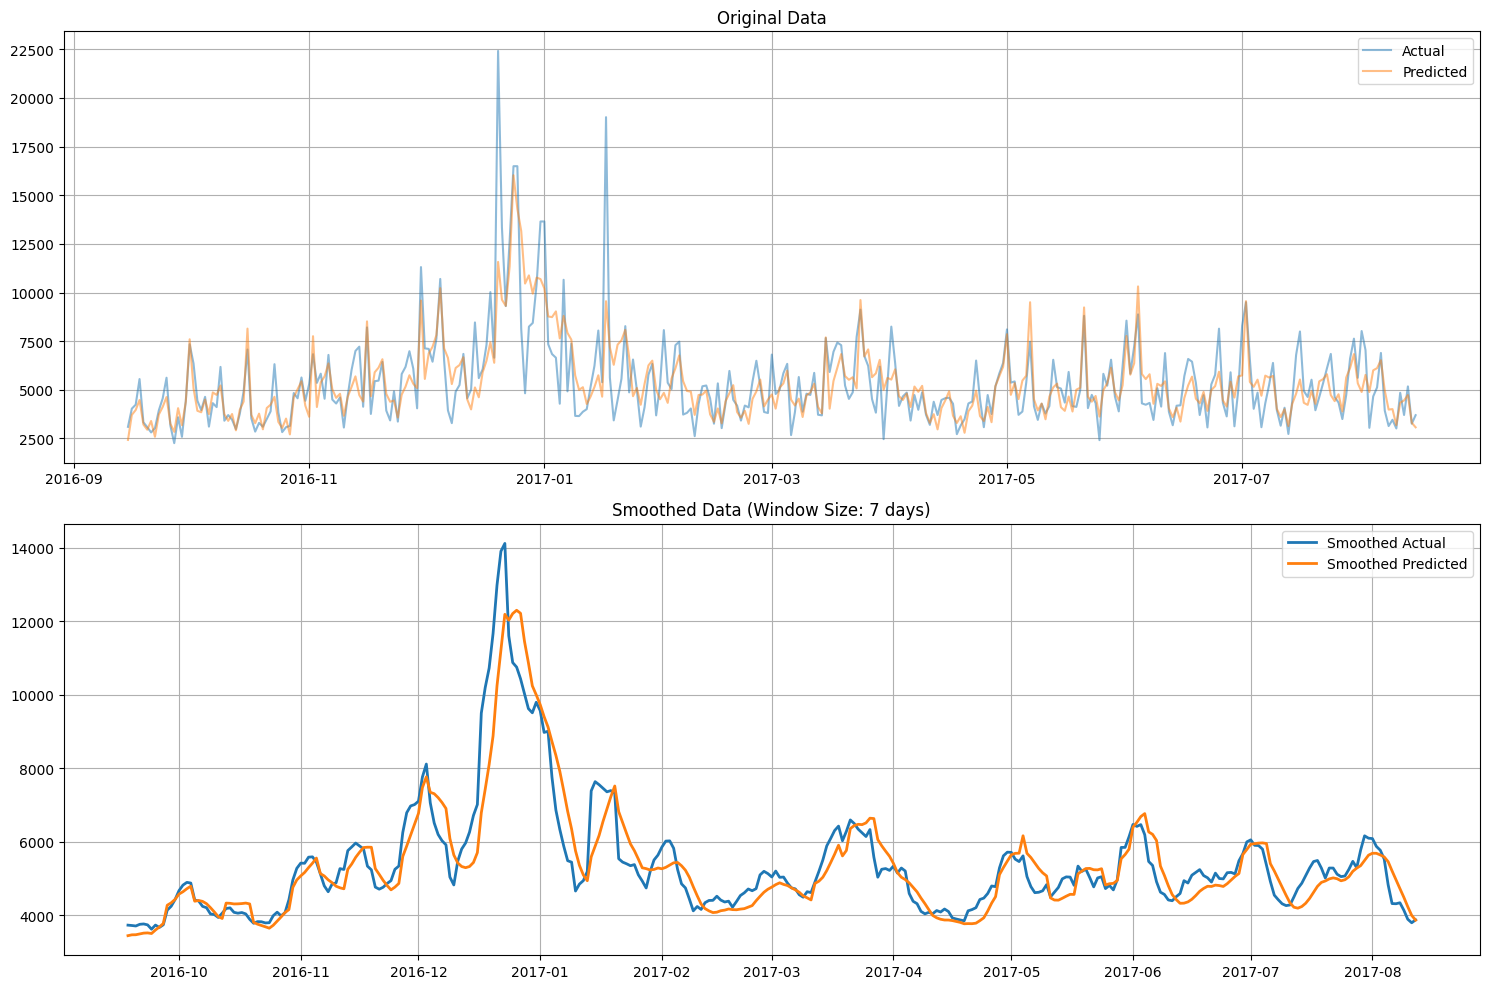

In [42]:
store_data = load_and_prepare_data()
daily_data = preprocess_data(store_data)
featured_data = create_features(daily_data)

# Split data
train_data, test_data = train_test_split_ts(featured_data)

# Fit model
model, train_exog = fit_sarima_model(train_data)

# Make validation predictions
predictions, conf_intervals = make_predictions(model, test_data, train_data)

# Plot validation results
plot_results(train_data, test_data, predictions, conf_intervals)

# Evaluate model
metrics, smoothed_actual, smoothed_preds = evaluate_smoothed_predictions(test_data, predictions, window_size=7)

Explaination of results : <br>

Without smoothing, we obtained the following measures.<br>
Raw_RMSE: 1412.85<br>
Raw_MAE: 906.41<br>
Raw_MAPE: 16.83<br>

RAW_MAE of 906.41 is a good number given that the daily sales are mostly in the range 4000 to 10,000 and the MAPE (mean-absolute percentage error) of 16.83%  is acceptable as anything below 20% in sales forecasting is considered good.<br>


With smooting where we are more focused on the trend rather than accurarate sales for every day, we achieved :<br>

Smoothed_RMSE: 645.64<br>
Smoothed_MAE: 442.73<br>
Smoothed_MAPE: 7.58<br>

There errors are greatly reduced with smoothing and the MAPE of 7.58% is great. 

From the first graph we can observe that the model's predictions (red) for 2017 closely track the actual test data (green), successfully capturing both the regular sales patterns and the magnitude of variations, validating our model's forecasting capability. The next two graphs compares our raw and smoothed predictions against actual sales data. The model effectively captures both regular sales patterns and major spikes across training (2013-2016, blue) and test periods (2017, red vs green), demonstrating strong predictive performance for store sales forecasting.



# Forecasting model to predict the sales for 3 particular items across all stores.

In this section, we will select the most frequent item from 3 different categories and build a forecasting model to predict the sales for these 3 particular items across all stores.

In [43]:
'''
In the below function, we perform analysis of sales forecasting for a specific product category.
We create some new time series features, fits SARIMA model, and generates predictions
Produce multiple visualizations comparing actual vs predicted sales.
Evaluate model performance using various metrics like RMSE, MAE, MAPE, and SMAPE.
'''
def analyze_forecast_item(df, category):
    item = df[df['family'] == category]['item_nbr'].iloc[0]
    item_data = df[df['item_nbr'] == item].copy()
    
    print(f"\nAnalyzing {category} item: {item}")
    print(f"Total records: {len(item_data)}")
    print(f"Date range: {item_data['date'].min()} to {item_data['date'].max()}")
    
    daily_sales = item_data.groupby('date')['unit_sales'].sum().reset_index()
    daily_sales.set_index('date', inplace=True)
    
    # Ensure continuous date range and fill missing values
    date_range = pd.date_range(start=daily_sales.index.min(),
                             end=daily_sales.index.max(),
                             freq='D')
    daily_sales = daily_sales.reindex(date_range)
    daily_sales['unit_sales'] = daily_sales['unit_sales'].fillna(0)

    # Create enhanced features
    daily_sales['day_of_week'] = daily_sales.index.dayofweek
    daily_sales['day_of_month'] = daily_sales.index.day
    daily_sales['month'] = daily_sales.index.month
    daily_sales['quarter'] = daily_sales.index.quarter
    daily_sales['year'] = daily_sales.index.year
    daily_sales['is_weekend'] = daily_sales.index.dayofweek.isin([5, 6]).astype(int)
    daily_sales['is_month_start'] = daily_sales.index.is_month_start.astype(int)
    daily_sales['is_month_end'] = daily_sales.index.is_month_end.astype(int)

    # Create lag features
    daily_sales['lag_1'] = daily_sales['unit_sales'].shift(1)
    daily_sales['lag_7'] = daily_sales['unit_sales'].shift(7)
    daily_sales['rolling_mean_7'] = daily_sales['unit_sales'].rolling(window=7).mean()
    daily_sales['rolling_std_7'] = daily_sales['unit_sales'].rolling(window=7).std()

    # Drop NaN values
    daily_sales = daily_sales.dropna()

    # Split into train and test
    train_size = int(len(daily_sales) * 0.8)
    train_data = daily_sales.iloc[:train_size]
    test_data = daily_sales.iloc[train_size:]

    print("\nTraining data:", train_data.index.min(), "to", train_data.index.max())
    print("Testing data:", test_data.index.min(), "to", test_data.index.max())

    # Model parameters
    order = (1, 1, 1)           
    seasonal_order = (1, 1, 1, 7)  

    # Create and fit model
    model = SARIMAX(train_data['unit_sales'],
                   exog=train_data[['is_weekend', 'is_month_start', 'is_month_end', 
                                   'rolling_mean_7', 'rolling_std_7']],
                   order=order,
                   seasonal_order=seasonal_order,
                   enforce_stationarity=False,
                   enforce_invertibility=False)

    results = model.fit(disp=False)

    # Make predictions
    predictions = results.get_forecast(
        steps=len(test_data),
        exog=test_data[['is_weekend', 'is_month_start', 'is_month_end', 
                        'rolling_mean_7', 'rolling_std_7']]
    )

    forecast = predictions.predicted_mean

    '''
    Applies rolling mean smoothing to a time series data.
    Uses a centered window approach to reduce noise in the data.
    Returns smoothed version of the input series.
    '''
    def smooth_series(series, window=7):
        return series.rolling(window=window, center=True).mean()

    smoothed_actual = smooth_series(test_data['unit_sales'])
    smoothed_forecast = smooth_series(pd.Series(forecast, index=test_data.index))
    smoothed_train = smooth_series(train_data['unit_sales'])

    '''
    Calculates multiple performance metrics for the forecast model
    Handles zero values appropriately when calculating percentage errors
    Returns a dictionary containing RMSE, MAE, MAPE, and SMAPE metric
    '''
    def evaluate_model(results, test_data, forecast):
        # Basic metrics
        rmse = np.sqrt(mean_squared_error(test_data['unit_sales'], forecast))
        mae = mean_absolute_error(test_data['unit_sales'], forecast)
        
        # MAPE for non-zero values
        non_zero_mask = test_data['unit_sales'] != 0
        mape = np.mean(np.abs((test_data['unit_sales'][non_zero_mask] - forecast[non_zero_mask]) / 
                            test_data['unit_sales'][non_zero_mask])) * 100
        
        # Symmetric MAPE
        smape = 100 * np.mean(2 * np.abs(test_data['unit_sales'] - forecast) / 
                            (np.abs(test_data['unit_sales']) + np.abs(forecast)))
        
        print("\nModel Performance Metrics:")
        print(f"RMSE: {rmse:.2f}")
        print(f"MAE: {mae:.2f}")
        print(f"MAPE (non-zero only): {mape:.2f}%")
        print(f"sMAPE: {smape:.2f}%")
        
        return {
            'rmse': rmse,
            'mae': mae,
            'mape': mape,
            'smape': smape
        }

    # Evaluate the model
    metrics = evaluate_model(results, test_data, forecast)

    # Complete time series plot
    plt.figure(figsize=(15, 7))
    plt.plot(train_data.index, train_data['unit_sales'], 
             label='Training Data', alpha=0.8)
    plt.plot(test_data.index, test_data['unit_sales'],
             label='Actual Test Data', alpha=0.8, color='green')
    plt.plot(test_data.index, forecast,
             label='Forecast', color='red', alpha=0.8)
    plt.title(f'Sales Forecast for {category} Item {item}')
    plt.xlabel('Date')
    plt.ylabel('Unit Sales')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Raw data comparison plot (test period only)
    plt.figure(figsize=(15, 7))
    plt.plot(test_data.index, test_data['unit_sales'],
             label='Actual Test Data', alpha=0.8, color='blue')
    plt.plot(test_data.index, forecast,
             label='Forecast', color='red', alpha=0.8)
    plt.title('Raw Data: Actual vs Predicted Sales')
    plt.xlabel('Date')
    plt.ylabel('Unit Sales')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Complete smoothed time series plot
    plt.figure(figsize=(15, 7))
    plt.plot(train_data.index, smoothed_train,
             label='Smoothed Training', alpha=0.8)
    plt.plot(test_data.index, smoothed_actual,
             label='Smoothed Actual', alpha=0.8, color='green')
    plt.plot(test_data.index, smoothed_forecast,
             label='Smoothed Forecast', color='red', alpha=0.8)
    plt.title('Smoothed Complete Time Series')
    plt.xlabel('Date')
    plt.ylabel('Unit Sales')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Smoothed comparison plot.
    plt.figure(figsize=(15, 7))
    plt.plot(test_data.index, smoothed_actual,
             label='Smoothed Actual Test Data', alpha=0.8, color='blue')
    plt.plot(test_data.index, smoothed_forecast,
             label='Smoothed Forecast', color='red', alpha=0.8)
    plt.title('Smoothed Data: Actual vs Predicted Sales')
    plt.xlabel('Date')
    plt.ylabel('Unit Sales')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return metrics

# Load data
df = pd.read_csv("top_category_items_data.csv")
df['date'] = pd.to_datetime(df['date'])




Analyzing CLEANING item: 168927
Total records: 40829
Date range: 2013-01-01 00:00:00 to 2017-08-15 00:00:00

Training data: 2013-01-08 00:00:00 to 2016-09-12 00:00:00
Testing data: 2016-09-13 00:00:00 to 2017-08-15 00:00:00

Model Performance Metrics:
RMSE: 99.58
MAE: 62.52
MAPE (non-zero only): 10.86%
sMAPE: 11.90%


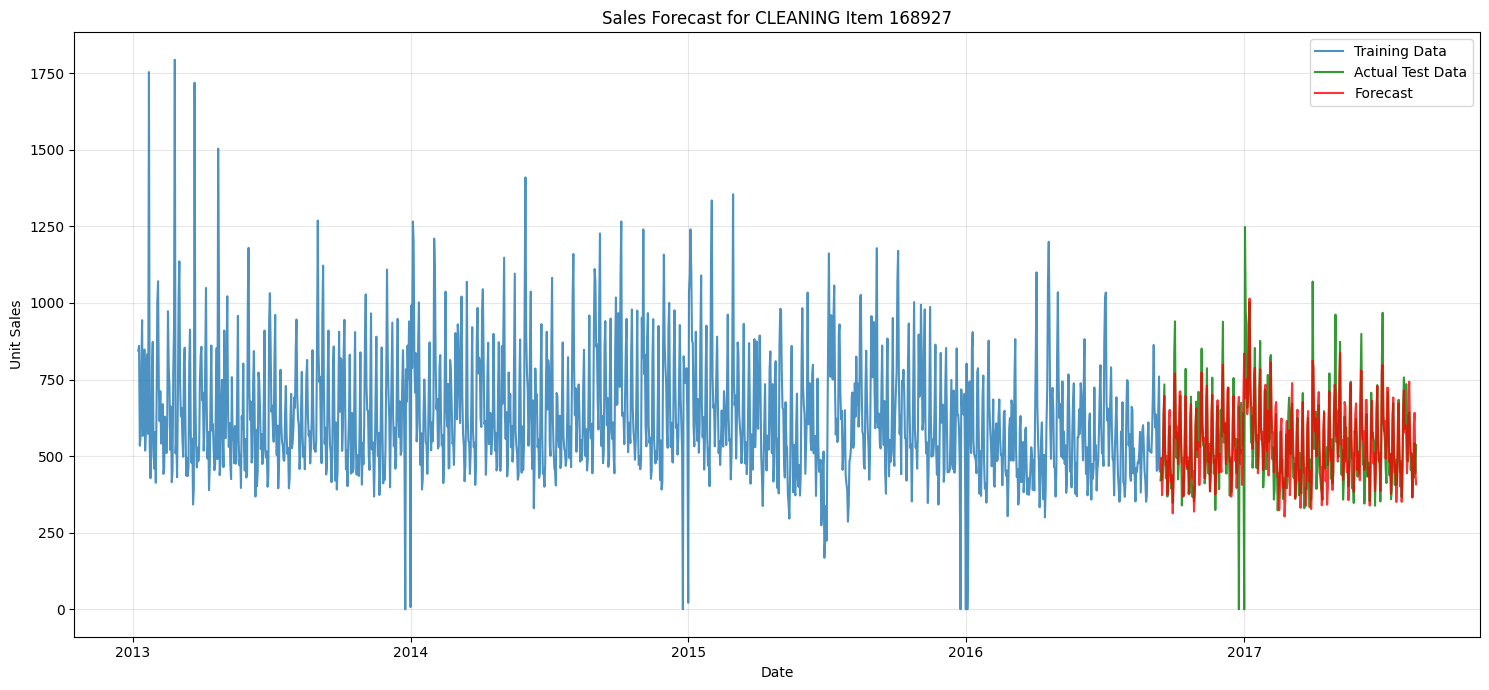

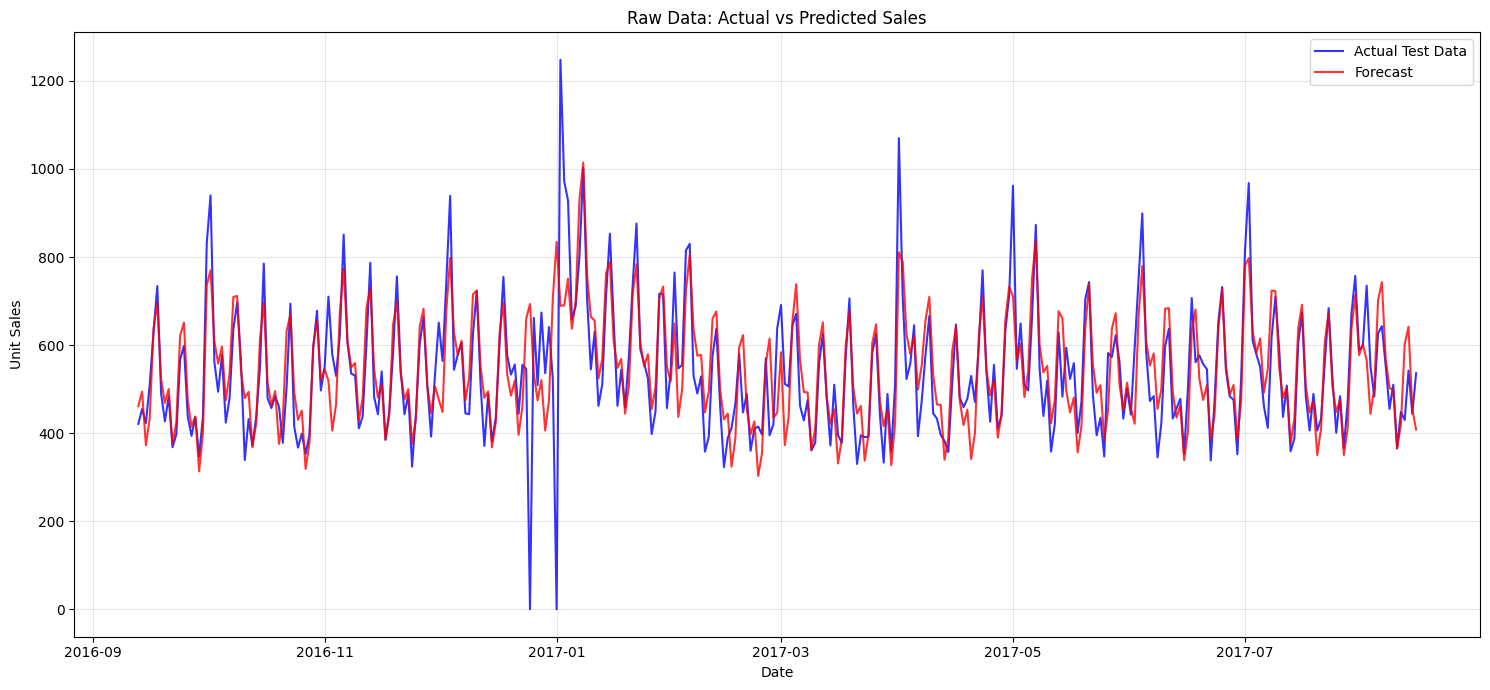

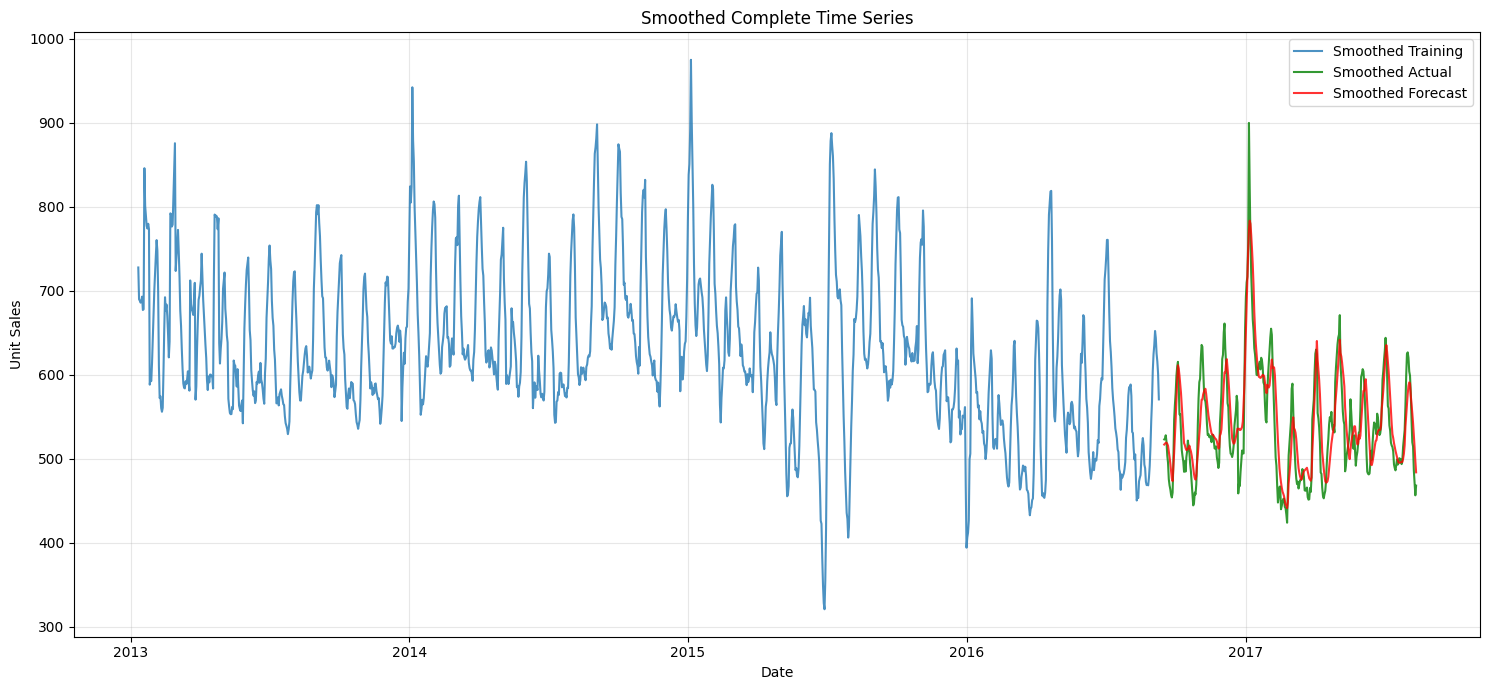

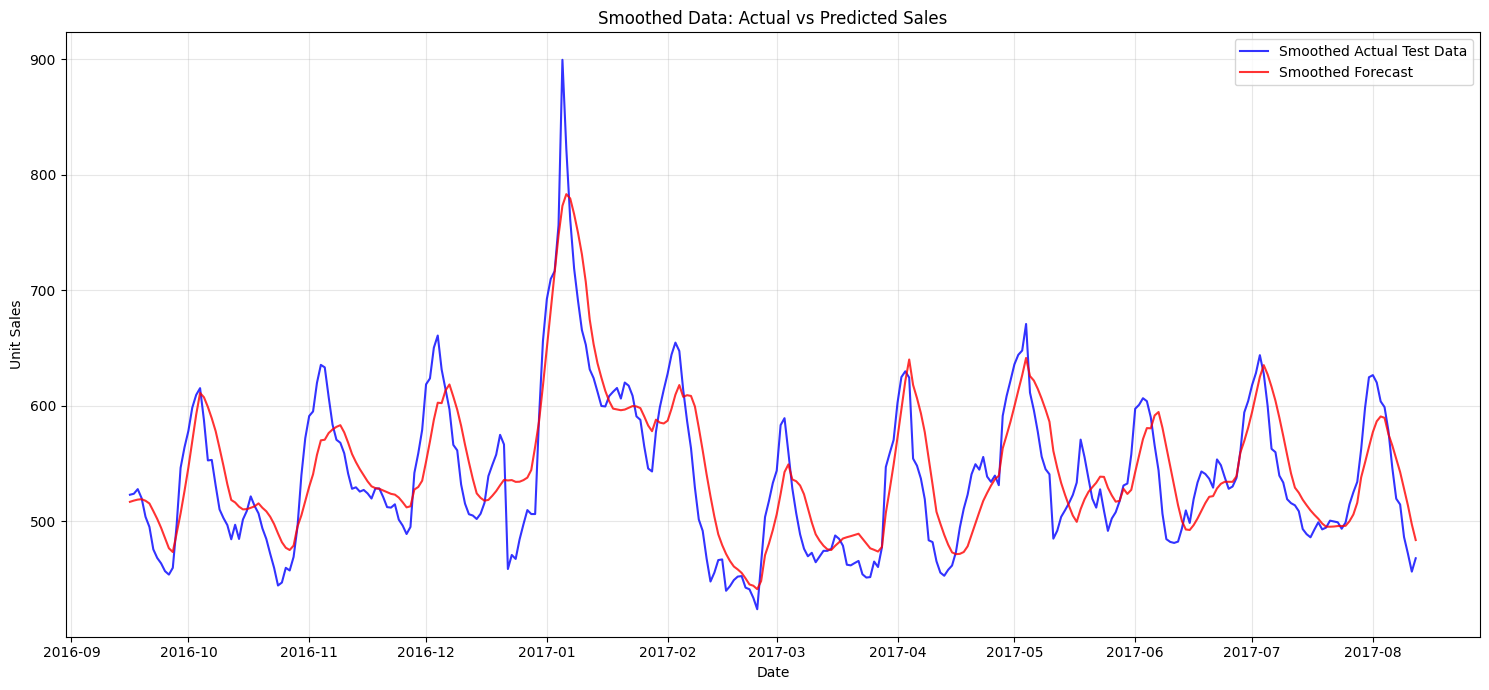


CLEANING:
RMSE: 99.58
MAE: 62.52
MAPE (non-zero only): 10.86%
sMAPE: 11.90%


In [44]:
# Analyze metrics for the item from CLEANING category
cleaning_metrics = analyze_forecast_item(df, 'CLEANING')

# Print summary of the results
print("\nCLEANING:")
print(f"RMSE: {cleaning_metrics['rmse']:.2f}")
print(f"MAE: {cleaning_metrics['mae']:.2f}")
print(f"MAPE (non-zero only): {cleaning_metrics['mape']:.2f}%")
print(f"sMAPE: {cleaning_metrics['smape']:.2f}%")


Analyzing DAIRY item: 1963277
Total records: 27920
Date range: 2016-02-15 00:00:00 to 2017-08-15 00:00:00

Training data: 2016-02-22 00:00:00 to 2017-04-28 00:00:00
Testing data: 2017-04-29 00:00:00 to 2017-08-15 00:00:00

Model Performance Metrics:
RMSE: 230.71
MAE: 168.15
MAPE (non-zero only): 10.21%
sMAPE: 10.08%


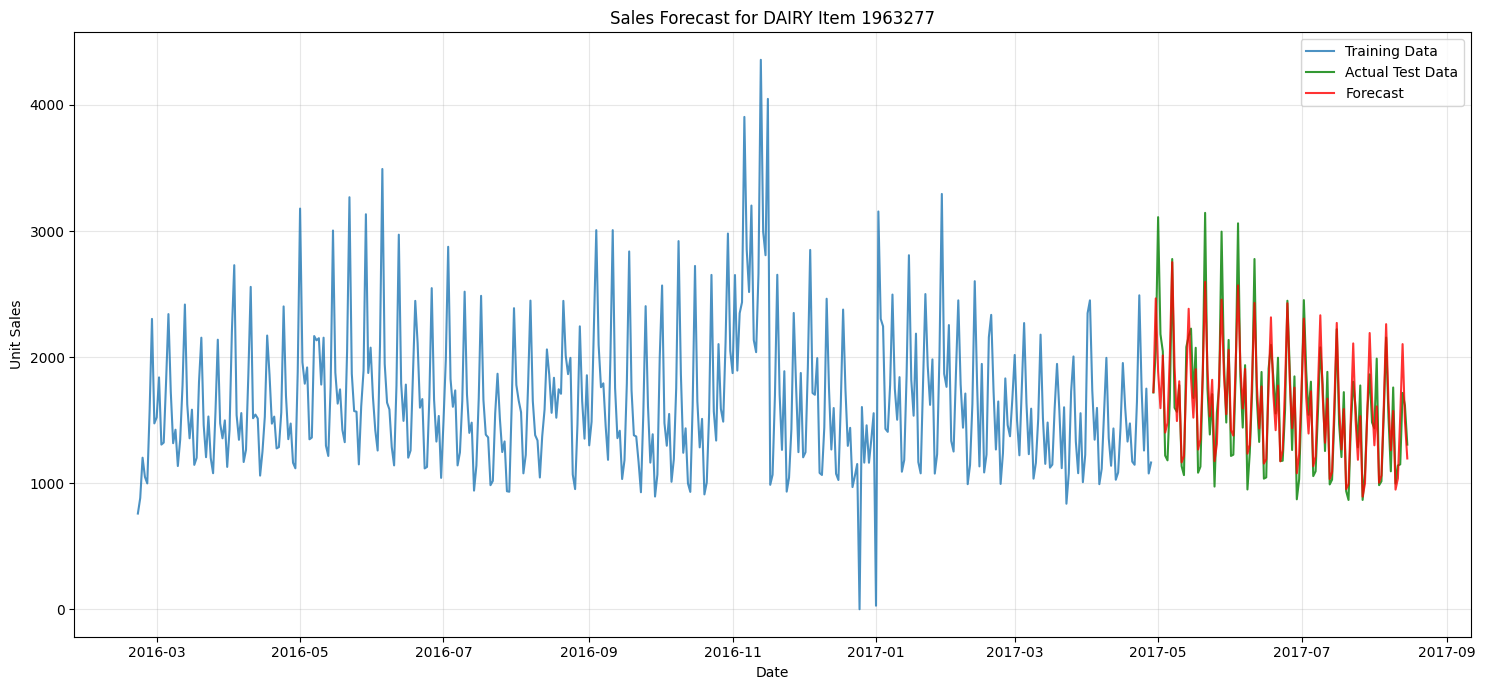

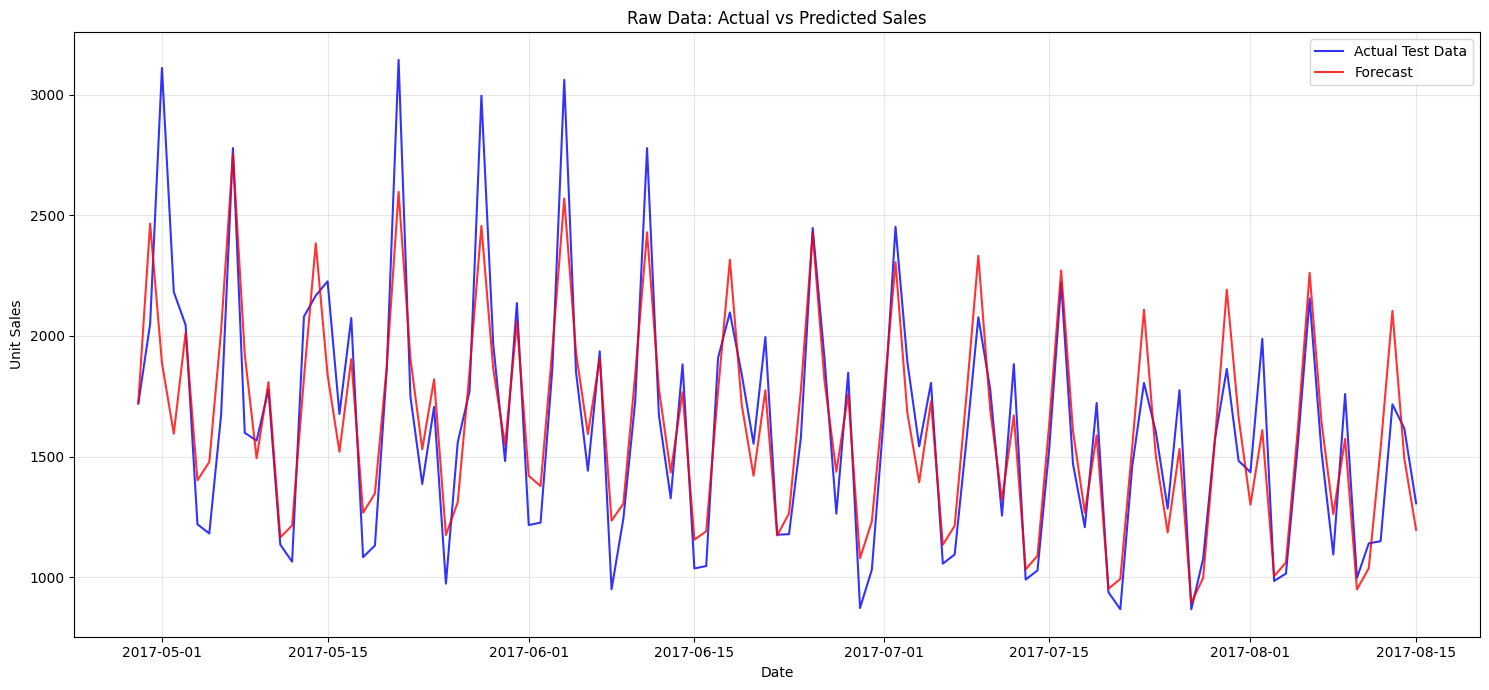

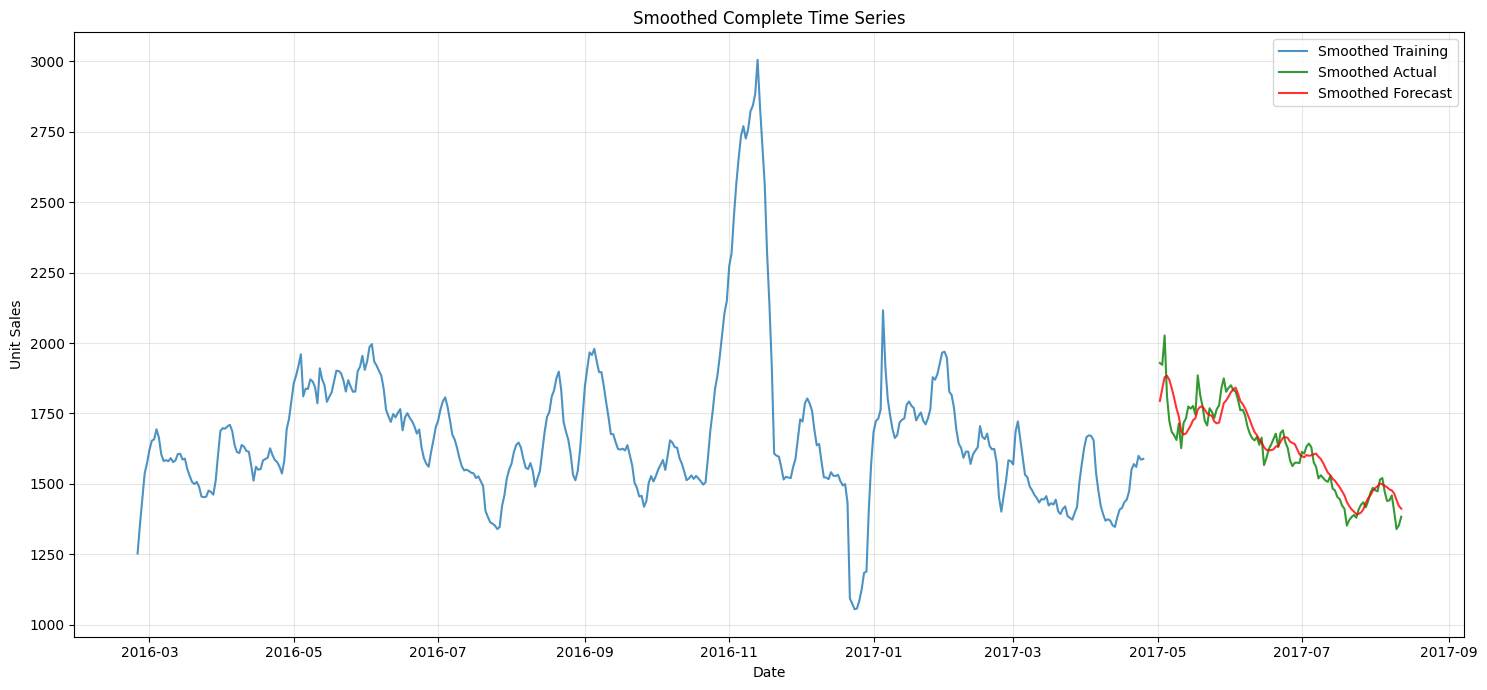

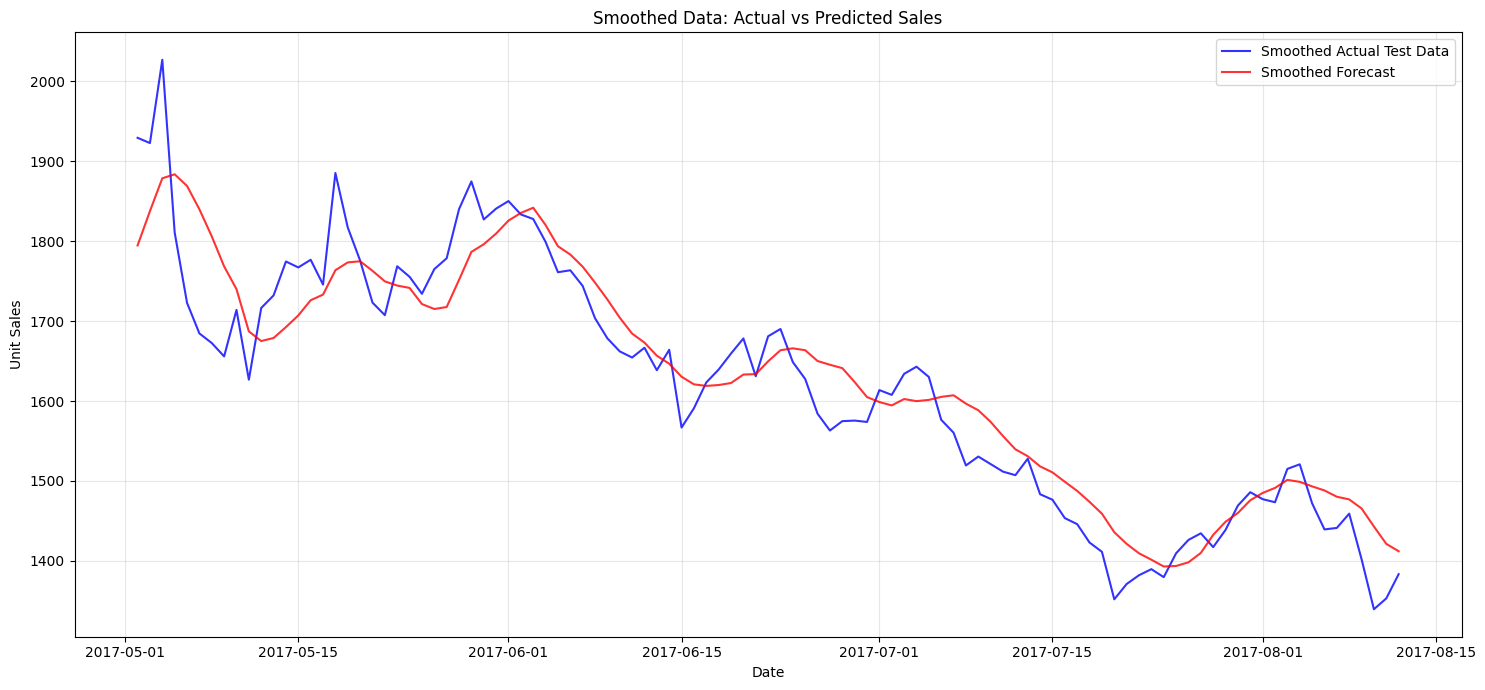


DAIRY:
RMSE: 230.71
MAE: 168.15
MAPE (non-zero only): 10.21%
sMAPE: 10.08%


In [45]:
# Analyze metrics for the item from DAIRY category
dairy_metrics = analyze_forecast_item(df, 'DAIRY')

# Print summary of results
print("\nDAIRY:")
print(f"RMSE: {dairy_metrics['rmse']:.2f}")
print(f"MAE: {dairy_metrics['mae']:.2f}")
print(f"MAPE (non-zero only): {dairy_metrics['mape']:.2f}%")
print(f"sMAPE: {dairy_metrics['smape']:.2f}%")



Analyzing PRODUCE item: 1489837
Total records: 25664
Date range: 2014-01-01 00:00:00 to 2017-08-15 00:00:00

Training data: 2014-01-08 00:00:00 to 2016-11-24 00:00:00
Testing data: 2016-11-25 00:00:00 to 2017-08-15 00:00:00

Model Performance Metrics:
RMSE: 102.16
MAE: 66.39
MAPE (non-zero only): 11.21%
sMAPE: 12.62%


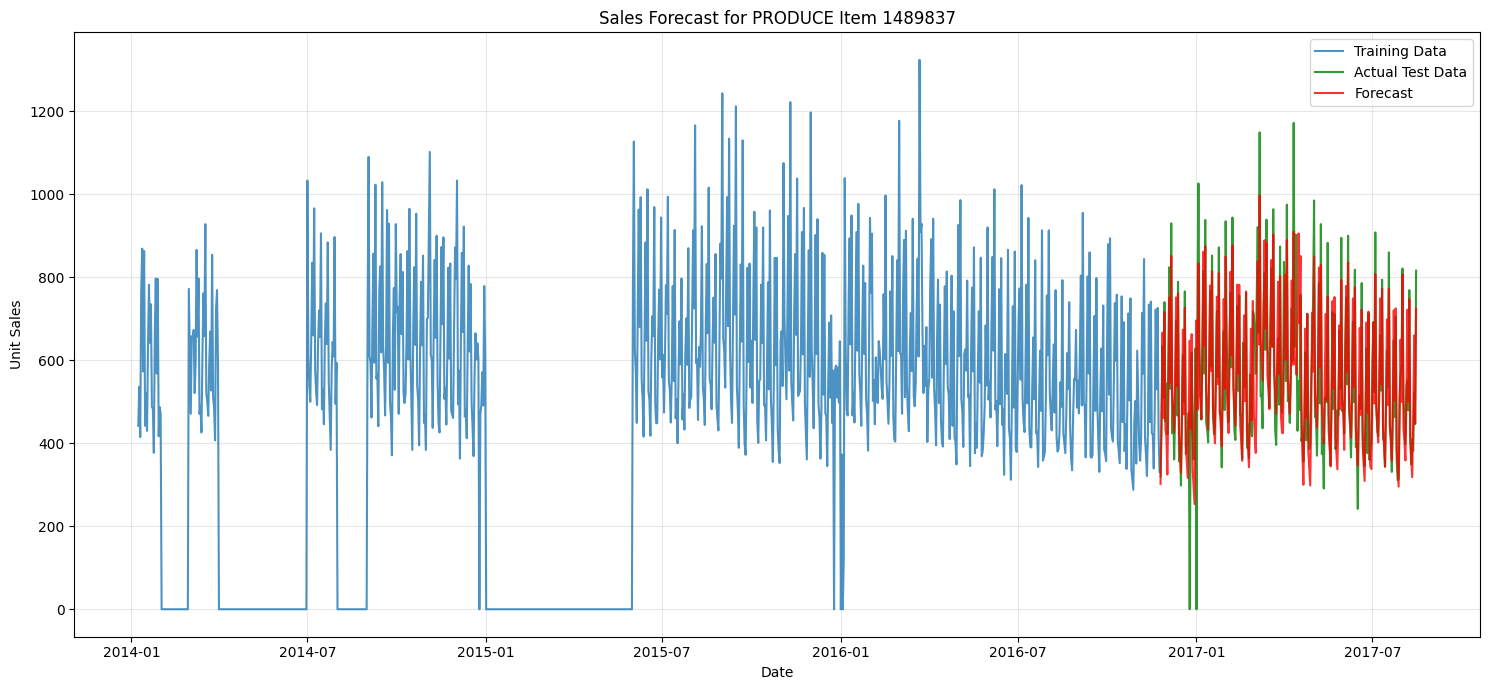

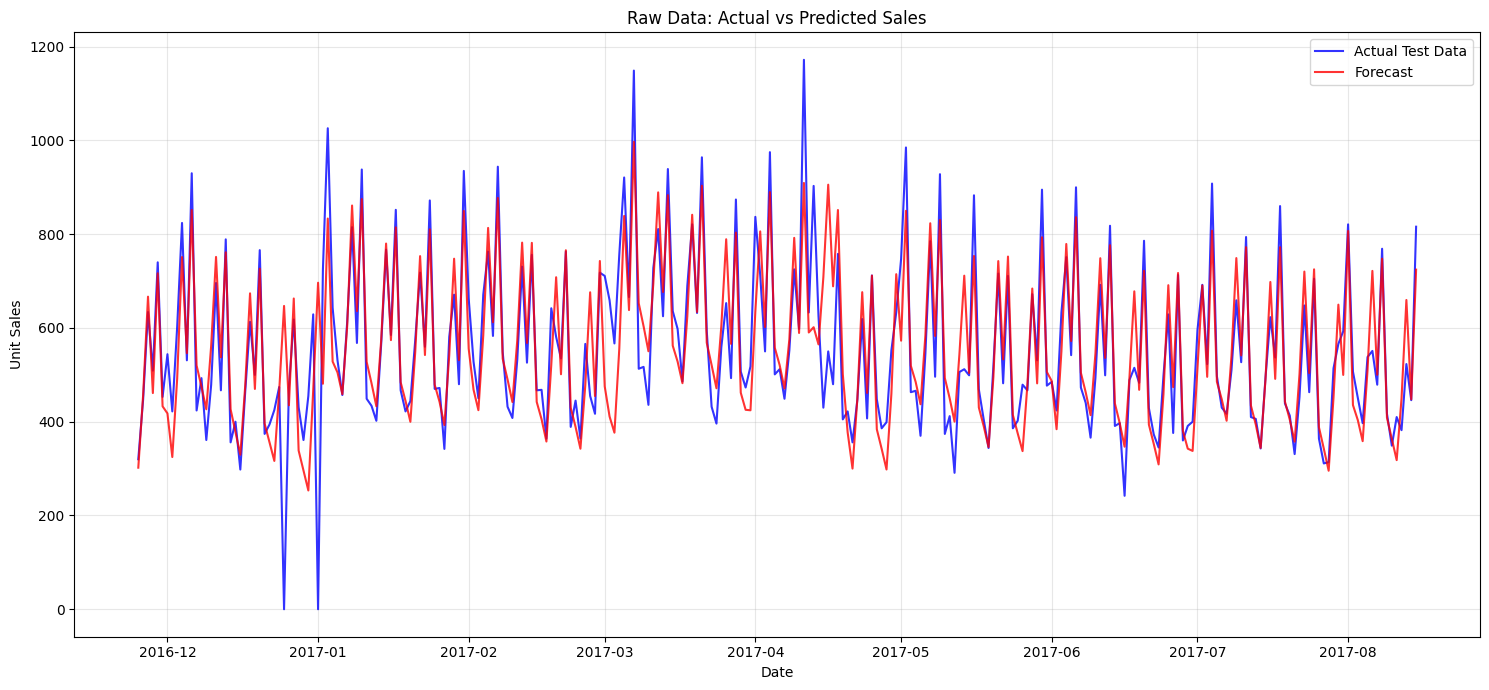

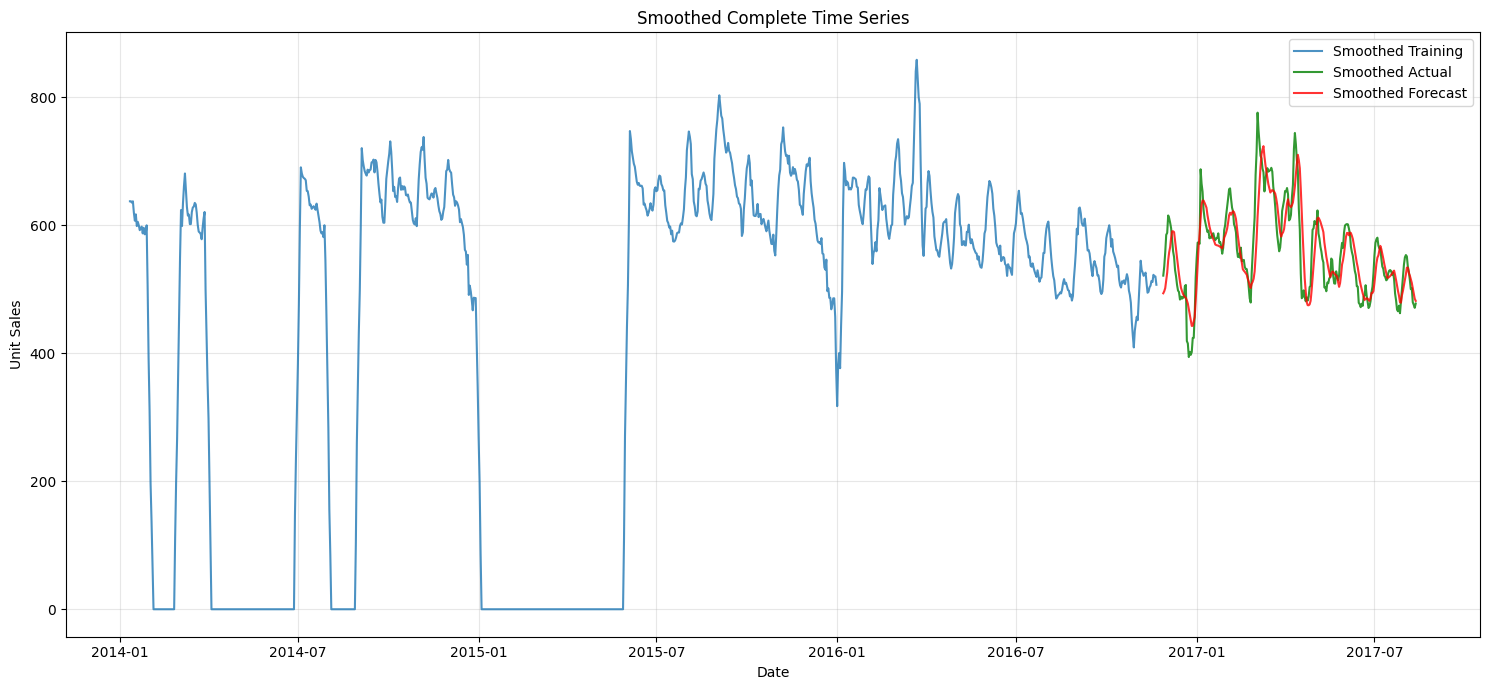

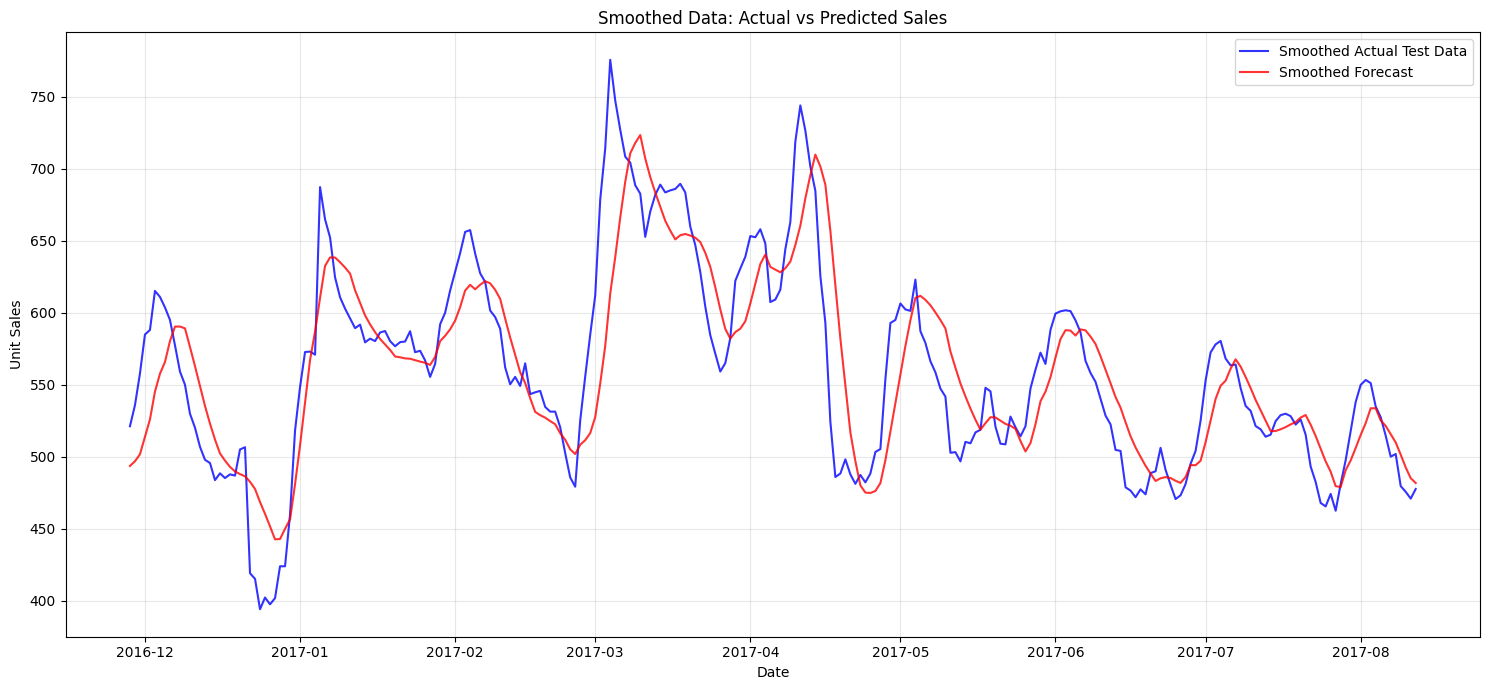


PRODUCE:
RMSE: 102.16
MAE: 66.39
MAPE (non-zero only): 11.21%
sMAPE: 12.62%


In [46]:
# Analyze metrics for the item from PRODUCE category
produce_metrics = analyze_forecast_item(df, 'PRODUCE')

# Print summary of results
print("\nPRODUCE:")
print(f"RMSE: {produce_metrics['rmse']:.2f}")
print(f"MAE: {produce_metrics['mae']:.2f}")
print(f"MAPE (non-zero only): {produce_metrics['mape']:.2f}%")
print(f"sMAPE: {produce_metrics['smape']:.2f}%")


Cleaning and dairy products show strong predictability with error rates of 11.90% and 10.08% respectively, 
Which tells us about the stable purchasing patterns and consistent consumer behavior across both categories.

Produce Category maintains decent accuracy with a 12.62% error rate despite having inherent challenges with seasonality and perishability,
while we are still able to capture product-specific patterns.

The SARIMA model showed great performance across both store-wide and item-level predictions, 
effectively capturing the sales patterns and seasonal trends and also maintaining strong accuracy despite varying product characteristics and sales volumes.

